# Initial settings

directoryのセットアップ  
project名をparent compoundとして、userとprojectを入力。

In [ ]:
import os
import glob

cwd = os.getcwd()
user = 'keetane'
project = 'ruxolitinib'
wd = os.path.join(cwd, '1_wd', user, project)
input_dir    = os.path.join(wd, 'input');    os.makedirs(input_dir, exist_ok=True)
results_dir  = os.path.join(wd, 'results');  os.makedirs(results_dir, exist_ok=True)
results_log  = os.path.join(results_dir, 'log');  os.makedirs(results_log, exist_ok=True)
toml_dir     = os.path.join(wd, 'toml');     os.makedirs(toml_dir, exist_ok=True)
toml_path = os.path.join(toml_dir, "sampling.toml")
sampling_log = os.path.join(results_dir, 'log'); os.makedirs(sampling_log, exist_ok=True)
input_dir

'/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/input'

Mol2Molのモデルの確認とdict化

In [8]:
# mol2mol modelのパスとモデル名のリストからdictを作成
model_path_list = glob.glob(cwd+'/priors/mol2mol*.prior') 
model_name_list = [os.path.basename(path).split('.')[0][8:] for path in model_path_list]  # reinvent, libinvent, linkinventを除外
model_dict = dict(zip(model_name_list, model_path_list))

# pubchem_ecfp4をappend
model_dict['pubchem']=glob.glob(cwd+'/priors/*.prior')[2]
model_dict


{'mmp': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_mmp.prior',
 'high_similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_high_similarity.prior',
 'medium_similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_medium_similarity.prior',
 'similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_similarity.prior',
 'scaffold_generic': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_scaffold_generic.prior',
 'scaffold': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_scaffold.prior',
 'pubchem': '/Users/keetane/Documents/apps/REINVENT4/priors/pubchem_ecfp4_with_count_with_rank_reinvent4_dict_voc.prior'}

PubChemからSMILESを呼び出す関数

In [9]:
import pubchempy as pcp
import requests
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import Image, display

# SMILESを取得するシンプルな関数
def get_simple_smiles(query, query_type='name'):
    # PubChemPyでCIDを取得
    compound = pcp.get_compounds(query, query_type)[0]
    cid = compound.cid

    # PubChem Pug REST APIを直接呼び出し
    api_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/JSON"
    response = requests.get(api_url)
    data = response.json()
    
    # 応答からSMILESを抽出
    compound_data = data['PC_Compounds'][0]
    smiles_options = {
        'Isomeric': None,
        'Absolute': None,
        'Canonical': None,
        'Connectivity': None
    }

    for prop in compound_data['props']:
        if prop['urn']['label'] == 'SMILES':
            smiles_name = prop['urn']['name']
            if smiles_name in smiles_options:
                smiles_options[smiles_name] = prop['value']['sval']
    
    # 優先順位: Isomeric -> Absolute -> Canonical -> Connectivity
    if smiles_options['Isomeric']:
        return smiles_options['Isomeric']
    elif smiles_options['Absolute']:
        return smiles_options['Absolute']
    elif smiles_options['Canonical']:
        return smiles_options['Canonical']
    else: # Connectivity
        return smiles_options['Connectivity']


ruxolitinib(=project)をparent compoundとしてSMILESを取得

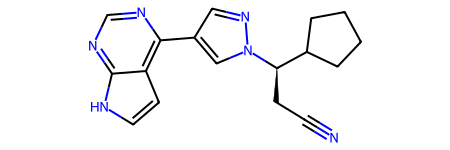

In [11]:
parent = project
parent_smiles = get_simple_smiles(parent, 'name')

# rxt_smilesをparent.smiとして保存
with open(f'{input_dir}' + "/parent.smi", "w") as f:
    f.write(parent_smiles) 

# RDKitで分子オブジェクトを作成し、描画
mol = Chem.MolFromSmiles(parent_smiles)

# Jupyter Notebook/Lab環境であれば、直接画像が表示されます
display(mol) 

tomlファイル作成とreinventの実行用関数

In [12]:
import subprocess as sp
def reinvent(model, # input model_dict.keys()
              input_smiles=input_dir+'/parent.smi', # default {input_dir}/parent.smi
                num_smiles=10000,
                  device='mps', 
                    sample_strategy='beamsearch',
                      temperature=1.0):
    if model.split('/')[-1].split('.')[0][:8]=='mol2mol_':
        model_name = model.split('/')[-1].split('.')[0][8:] # mol2mol_の後ろの文字列を取得
    else:
        model_name = model.split('/')[-1].split('.')[0][:13] # ==pubchem_ecfp4
    toml = f"""
run_type = "sampling"
device = "{device}"
json_out_config = "{results_log}_sampling.json"

[parameters]
model_file = "{model}"
output_file = "{results_dir}/{parent}_{model_name}.csv"
num_smiles = "{num_smiles}"
unique_molecules = true
randomize_smiles = true
smiles_file = "{input_smiles}"
sample_strategy = "{sample_strategy}"
temperature = "{temperature}"
"""
    with open(toml_path, "w") as f:
        f.write(toml)
    log_file = os.path.join(sampling_log, "sampling.log")
    cmd = ['reinvent', '-l', log_file, toml_path]
    sp.call(cmd)

reinvent関数のテスト実行

In [13]:
model_dict

{'mmp': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_mmp.prior',
 'high_similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_high_similarity.prior',
 'medium_similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_medium_similarity.prior',
 'similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_similarity.prior',
 'scaffold_generic': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_scaffold_generic.prior',
 'scaffold': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_scaffold.prior',
 'pubchem': '/Users/keetane/Documents/apps/REINVENT4/priors/pubchem_ecfp4_with_count_with_rank_reinvent4_dict_voc.prior'}

In [ ]:
model_name = 'mmp'
reinvent(model=model_dict[model_name],
          num_smiles=10000,
          sample_strategy='beamsearch',
        #   input_smiles=os.path.join(input_dir, "parent.smi"),
        #   device='mps',
        #   temperature=1.0
          )
pd.read_csv(os.path.join(results_dir, f"{parent}_{model_name}.csv")).head()

Empty DataFrame
Columns: [SMILES, Input_SMILES, Tanimoto, NLL]
Index: []

# Sampling molecules for all models

全モデルについて10000分子を生成し、ファイルを結合

In [ ]:
# 全モデルでreinventを実行
for model in model_dict.values():
    reinvent(model,
              num_smiles=10000,
              sample_strategy='beamsearch',
            #   input_smiles=os.path.join(input_dir, "parent.smi"),
            #   device='mps',
            #   temperature=1.0
              )


python(5758) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6418) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


全てのモデルの結果を結合

In [42]:
glob.glob(results_dir + f"/{parent}_*.csv")

['/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_all_model.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_high_similarity.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_scaffold_generic.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_pubchem_ecfp4.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_mmp.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_scaffold.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_similarity.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_medium_similarity.csv']

In [51]:
# 結果の読み込みと結合
# 出力結果のリストを作成
results_list = glob.glob(results_dir + f"/{parent}_*.csv")

# 結合ファイルが存在する場合は除外
all_model = f'{results_dir}/{parent}_all_model.csv'
results_list = [item for item in results_list if item != all_model]

# 出力結果リストからloopでdataframeを取得し結合、保存
df = []
for csv in results_list:
    temp = pd.read_csv(csv, sep=',')
    temp['model'] = csv.split('/')[-1].split('.')[0][len(parent)+1:]
    df.append(temp)
df = pd.concat(df, ignore_index=True)
df.to_csv(f'{results_dir}/{parent}_all_model.csv', index=False)
df[-5:]


SMILES  \
49852  CC(C)CS(=O)(=O)NC[C@H](C1CCCC1)n1ncc(-c2ncnc3[...   
49853  N#CC[C@H](C1CCCCC1)n1ccc(-c2ncnc3[nH]c(-c4ccc(...   
49854  Cc1ccc(S(=O)(=O)n2cc(-c3cnn(C(CC#N)C4CCCC4)c3)...   
49855  CS(=O)(=O)NC(=O)CCC(C1CCCC1)n1ccc(-c2ccnc3[nH]...   
49856  CS(=O)(=O)NC(=O)CC(C1CCCCC1)n1ncc(-c2ccnc3[nH]...   

                                       Input_SMILES  Tanimoto    NLL  \
49852  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.471698  12.56   
49853  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.443478  12.56   
49854  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.466019  12.59   
49855  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.385321  12.59   
49856  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.390909  12.65   

            model  
49852  similarity  
49853  similarity  
49854  similarity  
49855  similarity  
49856  similarity

重複の検出

7677 was duplicated
5254 molecules were unique


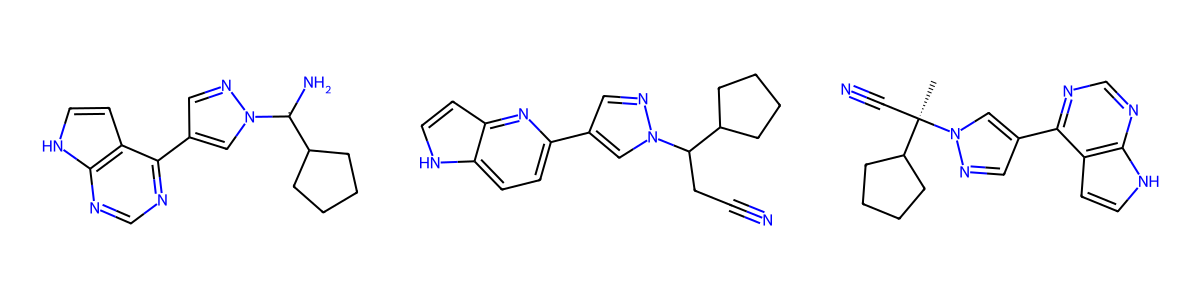

In [75]:
# SMILESの正規化
def duplicant_detector(smiles):
    mol = Chem.MolFromSmiles(smiles)
    canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
    return canonical_smiles

df['canonical_smiles'] = df.SMILES.map(lambda x : duplicant_detector(x))
# 重複の検出
df_dup = df[df.duplicated(subset='canonical_smiles')]
print(str(str(len(df_dup)) + ' was duplicated'))
print(str(len(df_dup.canonical_smiles.unique())) + ' molecules were unique')
Draw.MolsToGridImage(
    [mol for mol in df_dup.SMILES.map(lambda x : Chem.MolFromSmiles(x)).sample(3)],
    subImgSize=(400,300)
)

descriptorの計算

In [91]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import AllChem 
from rdkit.Chem import rdMolDescriptors 

def calculate_rdkit_descriptors(df, smiles_column='SMILES'):
    descriptor_functions = {
        'MW': Descriptors.MolWt,
        'LogP': Descriptors.MolLogP,
        'TPSA': Descriptors.TPSA,
        'HBA': Lipinski.NumHAcceptors,
        'HBD': Lipinski.NumHDonors,
        'Rotatable_Bonds': Descriptors.NumRotatableBonds,
        'Amide_Count': AllChem.CalcNumAmideBonds,
        'Ring_Count': rdMolDescriptors.CalcNumRings,
        'Aromatic_Ring_Count': rdMolDescriptors.CalcNumAromaticRings,
        'Fraction_CSP3': rdMolDescriptors.CalcFractionCSP3,
    }

    def smiles_to_mol(smiles):
        if pd.isna(smiles):
            return None
        try:
            mol = Chem.MolFromSmiles(str(smiles))
            # AssignStereoChemistry はこのエラーのために呼び出さない
            # Chem.AssignStereoChemistry(mol, cleanIt=True, force=True) 
            return mol
        except Exception as e:
            print(f"SMILESパース例外: '{smiles}' - {e}")
            return None

    def count_chiral_centers_fallback(mol):
        """
        AssignStereoChemistryが使えない場合のキラル中心数フォールバック関数。
        SMILESから直接エンコードされたキラル中心のみをカウントする傾向があります。
        """
        if mol is None:
            return 0
        
        num_chiral = 0
        for atom in mol.GetAtoms():
            # アトムに立体情報が設定されているか確認
            # CHI_UNSPECIFIED (0) 以外であれば、立体中心として認識されている
            if atom.GetChiralTag() != Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
                # この原子が四面体中心として妥当か確認 (結合数が4など)
                # より厳密なチェックが必要な場合もあるが、ここではシンプルに
                if atom.GetDegree() >= 3: 
                    num_chiral += 1
        return num_chiral

    df['mol_object'] = df[smiles_column].apply(smiles_to_mol)

    for desc_name, desc_func in descriptor_functions.items():
        df[desc_name] = df['mol_object'].apply(
            lambda mol: desc_func(mol) if mol is not None else None
        )
    
    # キラリティの有無を判定するディスクリプタを追加
    # フォールバック関数を使用
    df['NumChiralCenters'] = df['mol_object'].apply(
        lambda mol: count_chiral_centers_fallback(mol) if mol is not None else 0
    )
    # df['IsChiral'] = df['NumChiralCenters'].apply(lambda num: num > 0) # この行を削除
    
    df.drop(columns=['mol_object'], inplace=True) 
    
    return df


# csvを読み込み
csv_path = f"{results_dir}/{parent}_all_model.csv"
df = pd.read_csv(csv_path)

#　計算結果を保存
df = calculate_rdkit_descriptors(df)
df.to_csv(f'{results_dir}/{parent}_all_desc.csv', index=False)
df.head()

SMILES  \
0       N#CCC(C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
1  N#CC[C@@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
2       N#CCC(C1CCOCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
3         N#CCC(C1CCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
4   N#CC[C@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   

                                   Input_SMILES  Tanimoto   NLL  \
0  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.957746  1.54   
1  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.957746  2.69   
2  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.805195  2.93   
3  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.913043  3.01   
4  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.957746  3.12   

             model       MW     LogP   TPSA  HBA  HBD  Rotatable_Bonds  \
0  high_similarity  320.400  3.85648  83.18    5    1                4   
1  high_similarity  320.400  3.85648  83.18    5    1                4   
2  high_similarity  322.372  2.70278  92.41    6    1                4   
3  high_similarity  292.346  3.07628  83.18    5    1                4   
4  high_similarity  320.400  3.85648  83.18    5    1                4   

   Amide_Count  Ring_Count  Aromatic_Ring_Count  Fraction_CSP3  \
0            0           4                    3       0.444444   
1            0           4                    3       0.444444   
2            0           4                    3       0.411765   
3            0           4                    3       0.375000   
4            0           4                    3       0.444444   

   NumChiralCenters  
0                 0  
1                 1  
2                 0  
3                 0  
4                 1

In [24]:
df.model.unique()

array(['high_similarity', 'scaffold_generic', 'pubchem_ecfp4', 'mmp',
       'scaffold', 'similarity'], dtype=object)

# Visualizaion of Chemical Space

各Descriptorについてviolin plot


--- バイオリンプロット（各パラメータについてモデル別） ---


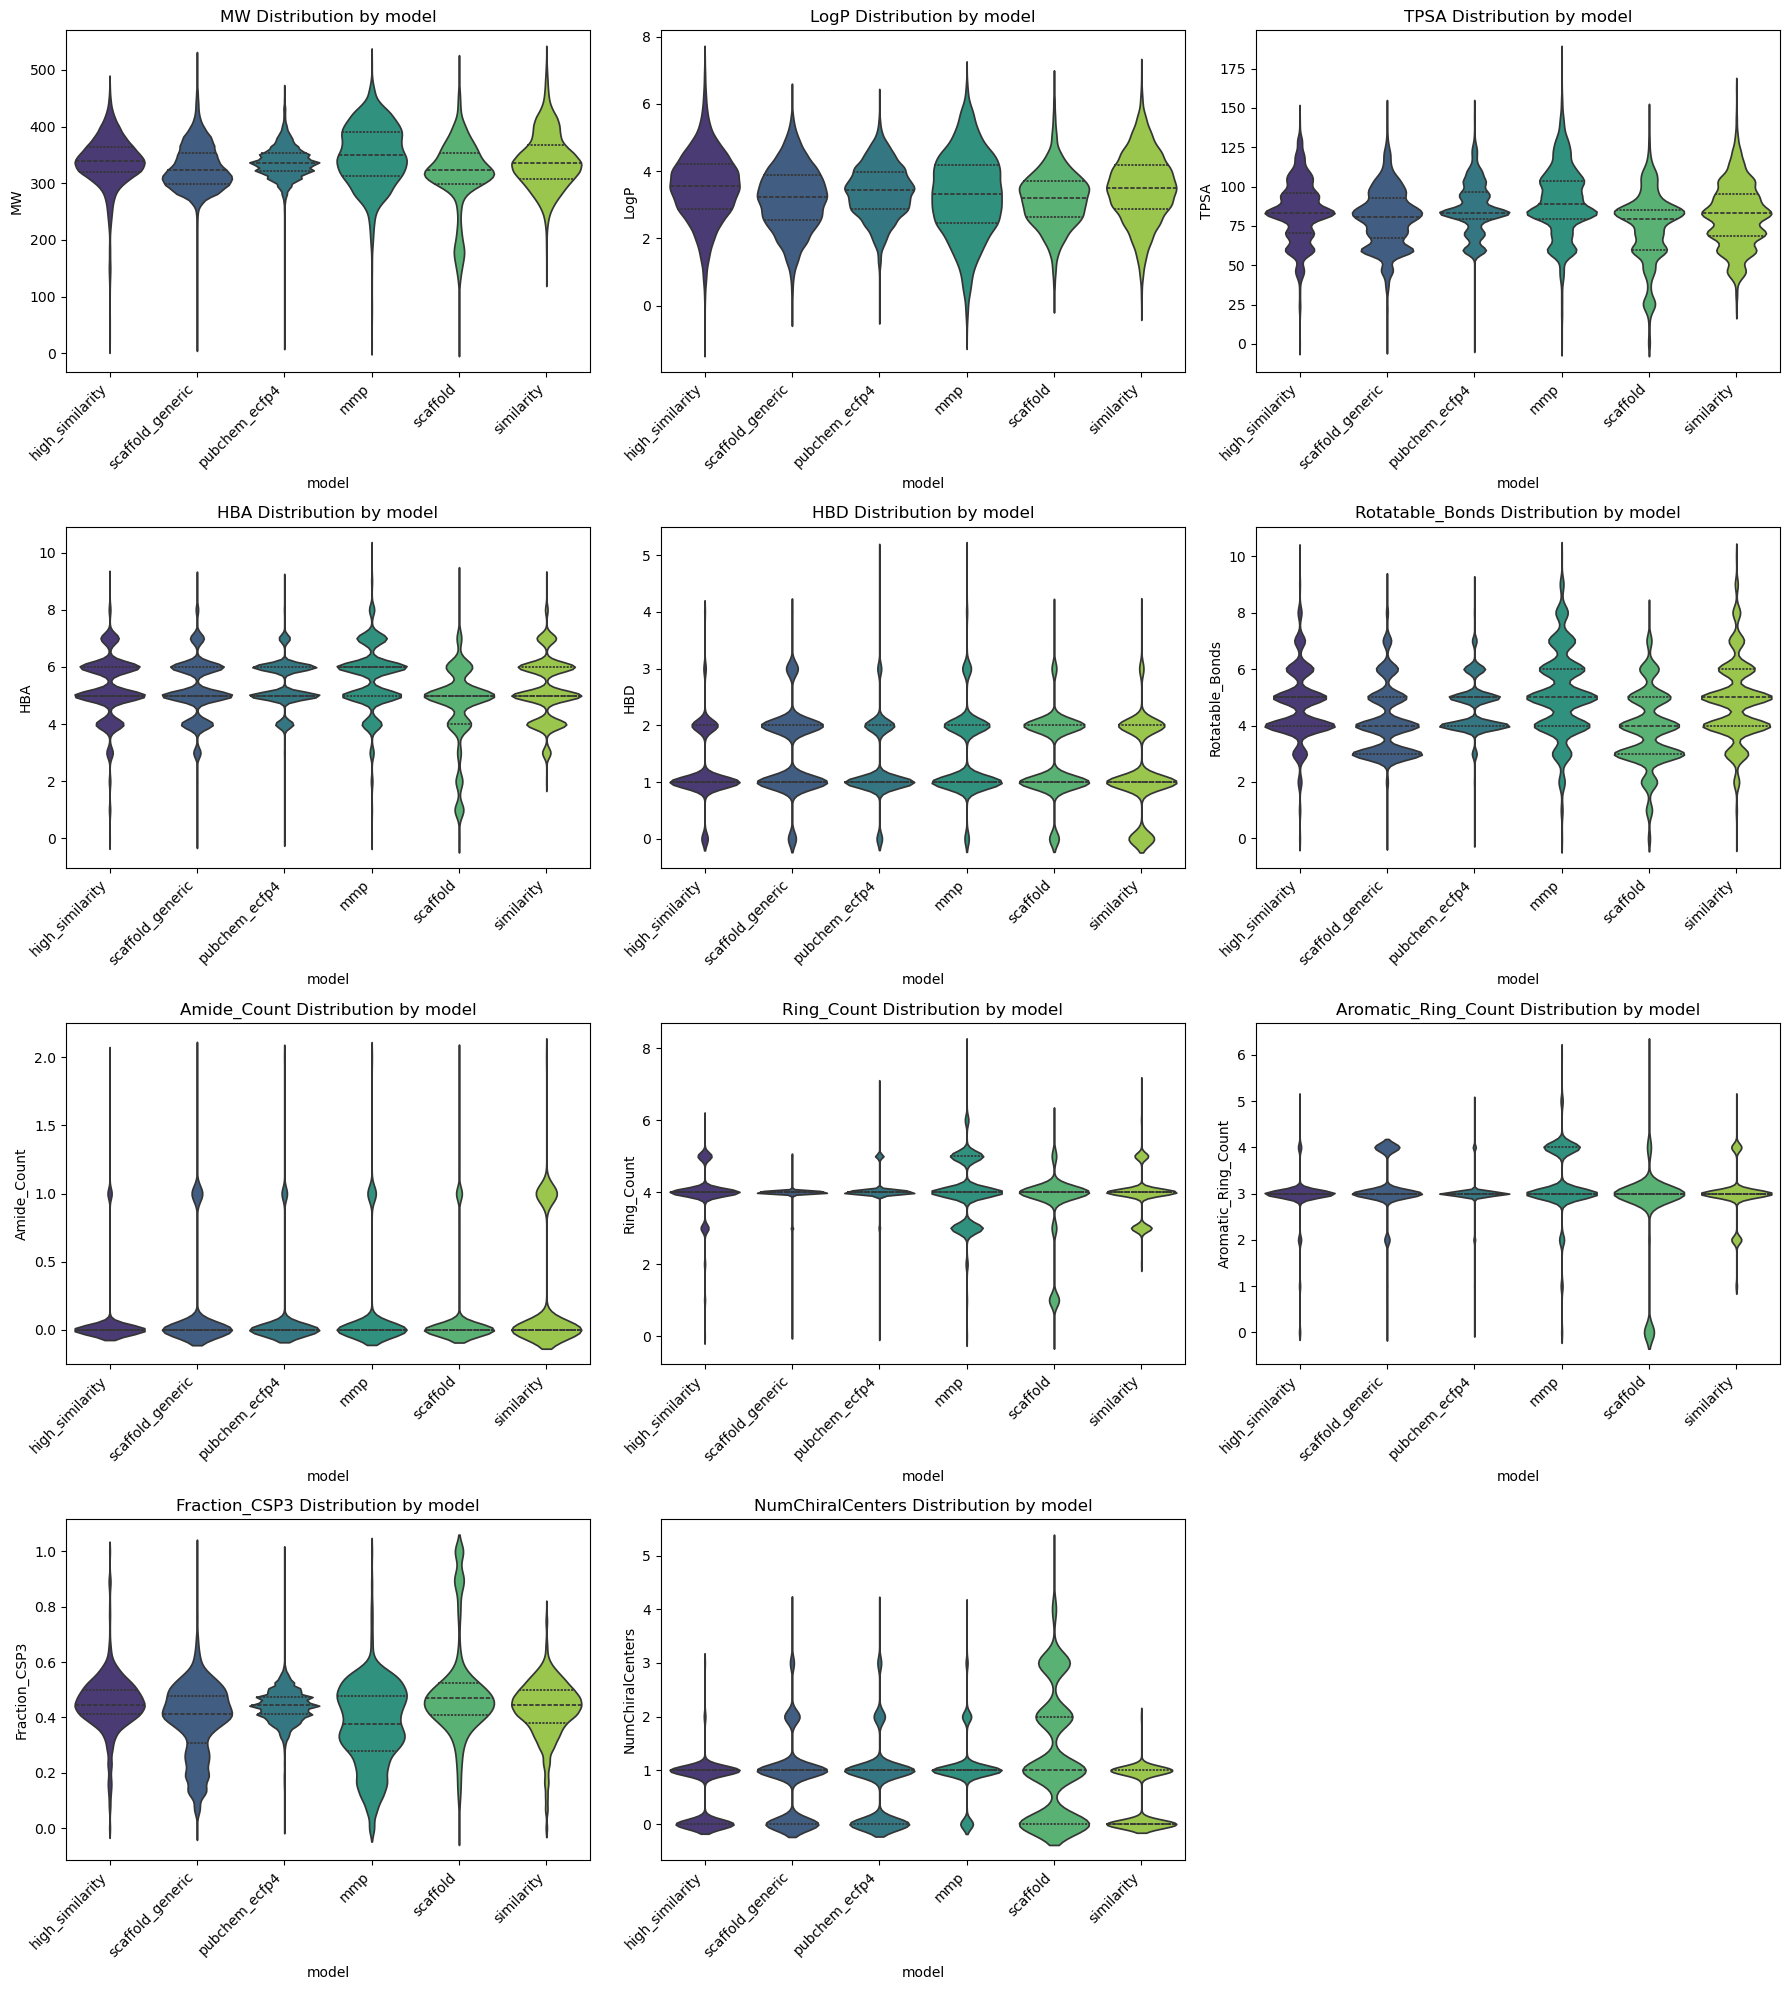

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings # warningsモジュールをインポート

# FutureWarningを無視する設定
warnings.filterwarnings("ignore", category=FutureWarning)

def visualize_chemical_space_distributions(df, model_column='model'):
    descriptors_to_plot = [
        'MW', 'LogP', 'TPSA', 'HBA', 'HBD',
        'Rotatable_Bonds', 'Amide_Count', 'Ring_Count',
        'Aromatic_Ring_Count', 'Fraction_CSP3', 'NumChiralCenters'
    ]

    print("\n--- バイオリンプロット（各パラメータについてモデル別） ---")
    num_plots = len(descriptors_to_plot)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    if num_plots == 0:
        print("警告: プロットする記述子が指定されていません。")
        return

    plt.figure(figsize=(num_cols * 6, num_rows * 5))

    for i, desc in enumerate(descriptors_to_plot):
        plt.subplot(num_rows, num_cols, i + 1)
        if desc not in df.columns:
            print(f"警告: カラム '{desc}' がDataFrameに存在しません。スキップします。")
            continue
        
        if df[desc].isnull().all():
            print(f"警告: カラム '{desc}' に有効なデータがありません（全てNaN）。スキップします。")
            continue

        sns.violinplot(data=df, x=model_column, y=desc, palette="viridis", inner="quartile")
        plt.title(f'{desc} Distribution by {model_column}')
        plt.xlabel(model_column)
        plt.ylabel(desc)
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

df = pd.read_csv(f'{results_dir}/{parent}_all_desc.csv')
visualize_chemical_space_distributions(df)


Tanimoto係数とNLLをscatter plot

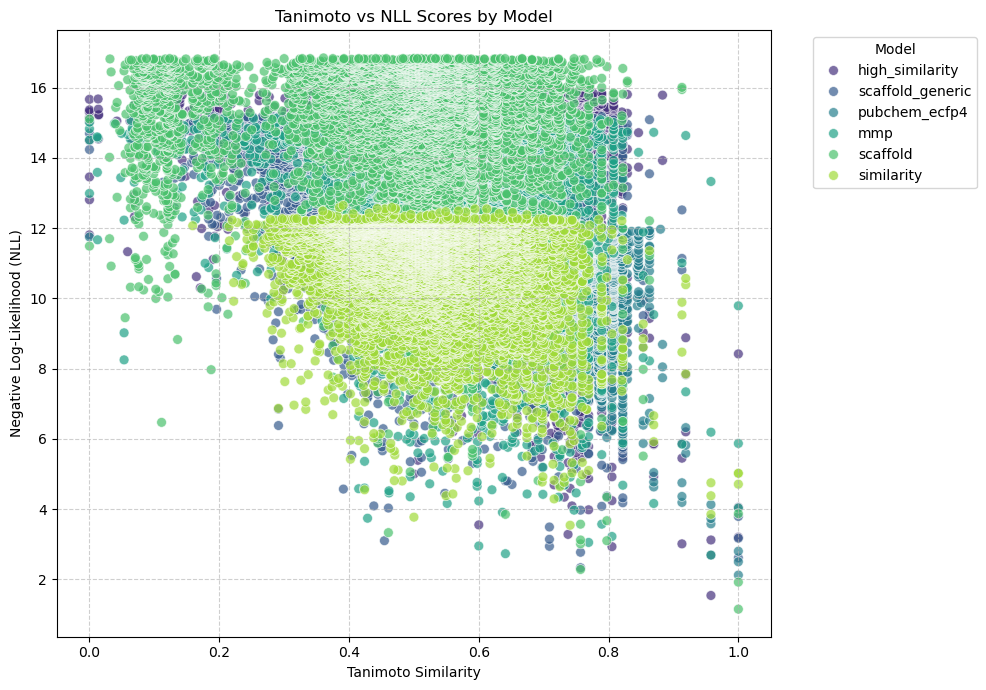

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_tanimoto_nll_scatterplot(df):
    # 必要なカラムが存在するか確認
    required_columns = ['Tanimoto', 'NLL', 'model']
    for col in required_columns:
        if col not in df.columns:
            print(f"エラー: 必須カラム '{col}' がDataFrameに存在しません。")
            return

    plt.figure(figsize=(10, 7)) # プロットのサイズを設定

    # 散布図の作成
    # hue='model' で 'model' カラムの値に基づいて色分けされます。
    sns.scatterplot(data=df, x='Tanimoto', y='NLL', hue='model', palette='viridis', s=50, alpha=0.7)

    plt.title('Tanimoto vs NLL Scores by Model') # タイトル
    plt.xlabel('Tanimoto Similarity') # x軸ラベル
    plt.ylabel('Negative Log-Likelihood (NLL)') # y軸ラベル
    plt.grid(True, linestyle='--', alpha=0.6) # グリッドを追加
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left') # 凡例をプロットの外に配置
    plt.tight_layout() # レイアウトを調整してラベルが重ならないようにする
    plt.show()
create_tanimoto_nll_scatterplot(df)

トレリスで散布図を表示


--- トレリスプロット（Tanimoto vs NLL スコア、モデル別） ---


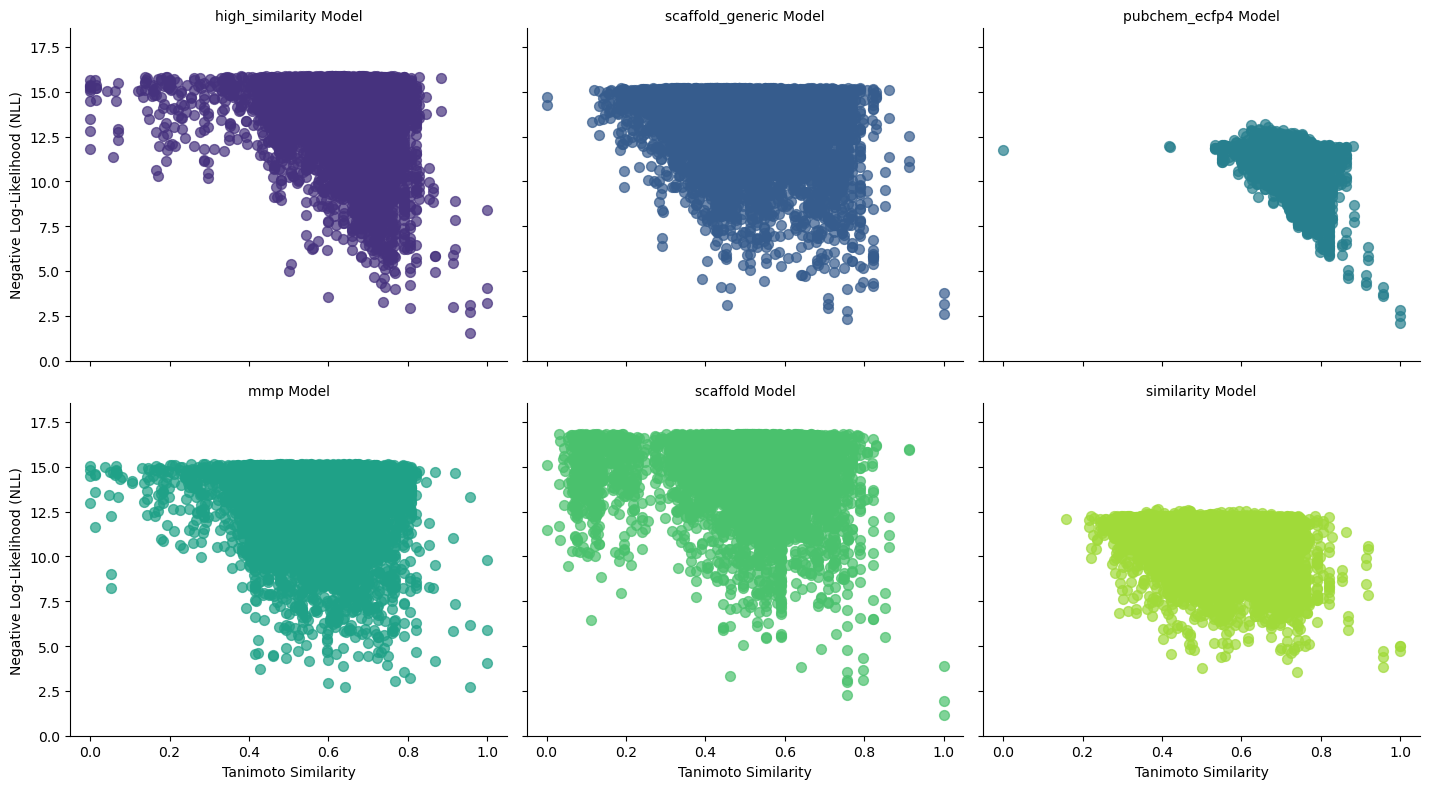

In [69]:
# FutureWarningを無視する設定
warnings.filterwarnings("ignore", category=FutureWarning)

def create_tanimoto_nll_trellis_plot(df):
    """
    TanimotoとNLLのスコアをモデルの値ごとに色分けしたトレリス散布図を作成します。

    Args:
        df (pd.DataFrame): 'Tanimoto', 'NLL', 'model' カラムを含むDataFrame。
    """
    
    # 必要なカラムが存在するか確認
    required_columns = ['Tanimoto', 'NLL', 'model']
    for col in required_columns:
        if col not in df.columns:
            print(f"エラー: 必須カラム '{col}' がDataFrameに存在しません。トレリスプロットを生成できません。")
            return

    # DataFrameが空でないか、または必要なデータが十分に存在するかを確認
    if df.empty or df['Tanimoto'].isnull().all() or df['NLL'].isnull().all():
        print("警告: グラフ描画に必要なデータが不足しているか、全て欠損値です。トレリスプロットを生成できません。")
        return

    print("\n--- トレリスプロット（Tanimoto vs NLL スコア、モデル別） ---")
    
    # FacetGrid を使用してトレリスプロットを作成
    # col='model' で 'model' カラムの値に基づいて各サブプロットが作成されます。
    # col_wrap は1行あたりのサブプロット数です。
    # height は各サブプロットの高さ、aspect はアスペクト比です。
    g = sns.FacetGrid(df, col='model', col_wrap=3, height=4, aspect=1.2, palette='viridis', hue='model')

    # 各サブプロットに散布図を描画
    # plt.scatter を map メソッドに渡します。
    g.map(plt.scatter, 'Tanimoto', 'NLL', alpha=0.7, s=50)

    # タイトルと軸ラベルの設定
    # set_axis_labels は全サブプロットの軸ラベルを設定します。
    # set_titles は各サブプロットのタイトルを設定します。
    g.set_axis_labels('Tanimoto Similarity', 'Negative Log-Likelihood (NLL)')
    g.set_titles(col_template='{col_name} Model') # '{col}' を '{col_name}' に変更    
    # 凡例はFacetGridが自動的に設定してくれることが多いですが、
    # 明示的に追加する場合は add_legend() を使用します。
    # hue を指定しているため、通常は自動で凡例が表示されます。
    # g.add_legend(title='Model') 

    # 必要に応じてY軸の範囲を調整
    g.set(ylim=(0, df['NLL'].max() * 1.1)) # NLLの最大値の1.1倍を上限とする

    plt.tight_layout() # レイアウトを調整して、サブプロットやタイトルが重ならないようにします。
    plt.show() # プロットを表示します。
    
create_tanimoto_nll_trellis_plot(df)

箱ひげ図とバイオリンプロットで比較

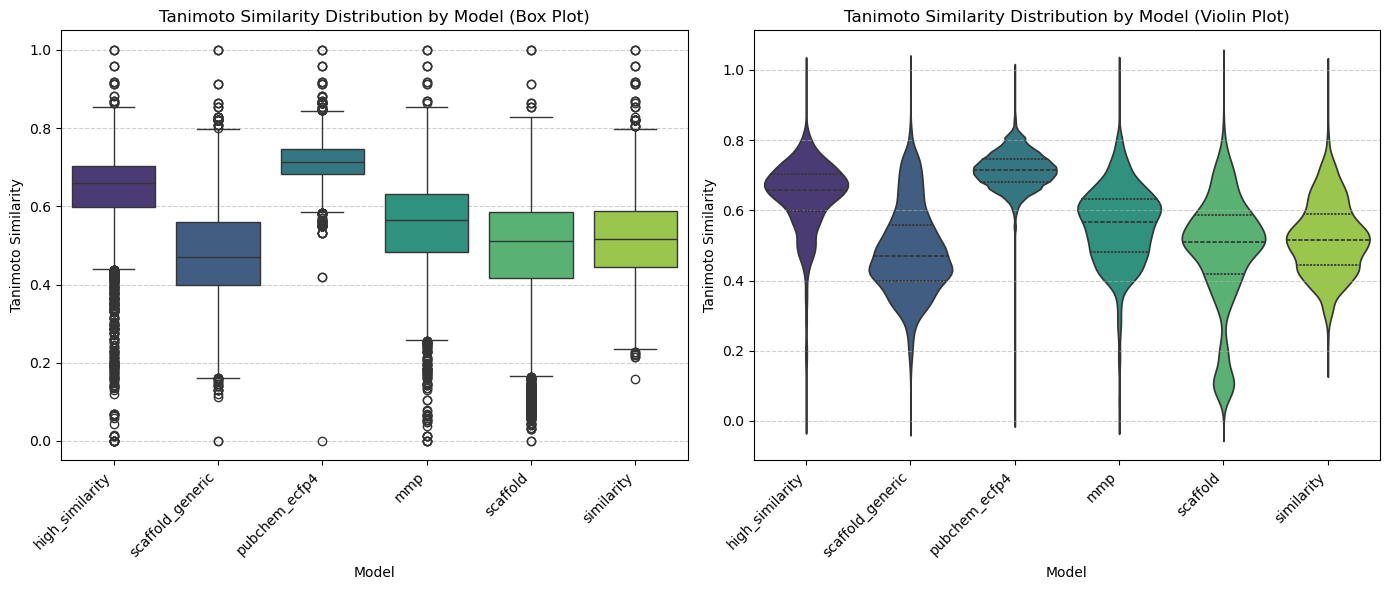

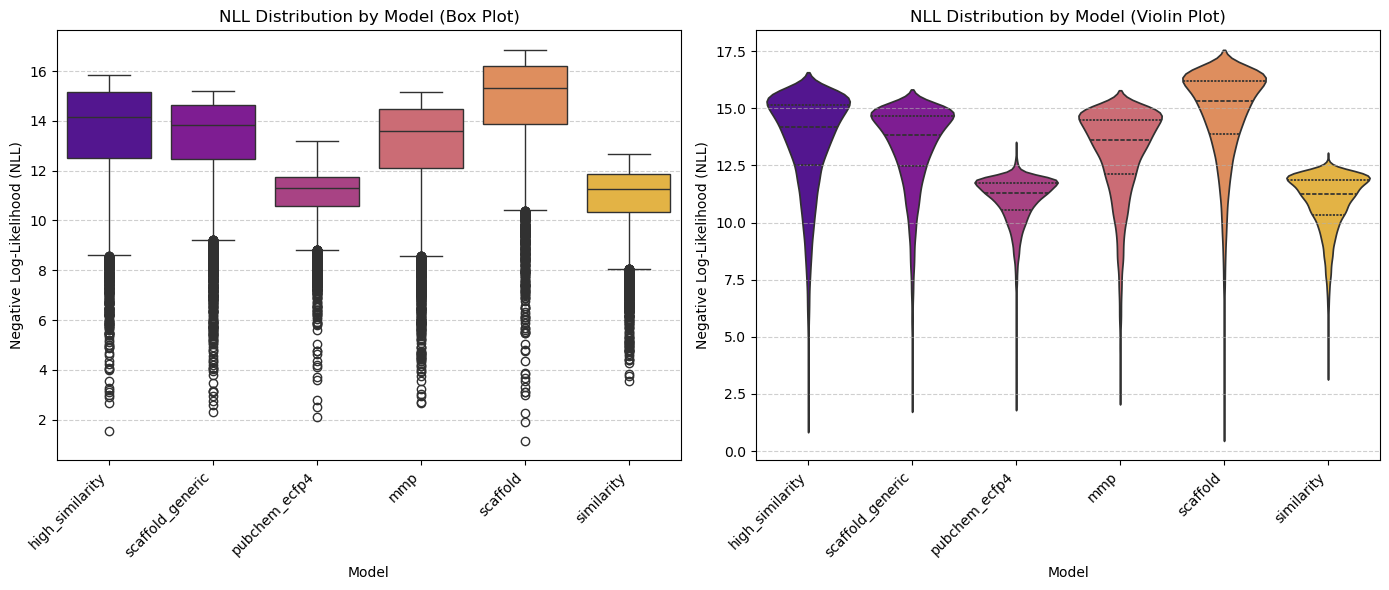

In [71]:
def create_box_violin_plots(df):
    """
    TanimotoとNLLスコアのモデルごとの箱ひげ図とバイオリンプロットを作成します。

    Args:
        df (pd.DataFrame): 'Tanimoto', 'NLL', 'model' カラムを含むDataFrame。
    """
    
    required_columns = ['Tanimoto', 'NLL', 'model']
    for col in required_columns:
        if col not in df.columns:
            print(f"エラー: 必須カラム '{col}' がDataFrameに存在しません。プロットを生成できません。")
            return

    if df.empty or df['Tanimoto'].isnull().all() or df['NLL'].isnull().all():
        print("警告: グラフ描画に必要なデータが不足しているか、全て欠損値です。プロットを生成できません。")
        return

    # Tanimotoスコアの箱ひげ図とバイオリンプロット
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1) # 1行2列の1番目のサブプロット
    sns.boxplot(data=df, x='model', y='Tanimoto', palette='viridis')
    plt.title('Tanimoto Similarity Distribution by Model (Box Plot)')
    plt.xlabel('Model')
    plt.ylabel('Tanimoto Similarity')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2) # 1行2列の2番目のサブプロット
    sns.violinplot(data=df, x='model', y='Tanimoto', palette='viridis', inner="quartile")
    plt.title('Tanimoto Similarity Distribution by Model (Violin Plot)')
    plt.xlabel('Model')
    plt.ylabel('Tanimoto Similarity')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # NLLスコアの箱ひげ図とバイオリンプロット
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x='model', y='NLL', palette='plasma')
    plt.title('NLL Distribution by Model (Box Plot)')
    plt.xlabel('Model')
    plt.ylabel('Negative Log-Likelihood (NLL)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2)
    sns.violinplot(data=df, x='model', y='NLL', palette='plasma', inner="quartile")
    plt.title('NLL Distribution by Model (Violin Plot)')
    plt.xlabel('Model')
    plt.ylabel('Negative Log-Likelihood (NLL)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()
    
create_box_violin_plots(df)


# Scaffold/MMP analysis

Ruxolitinibについて解析

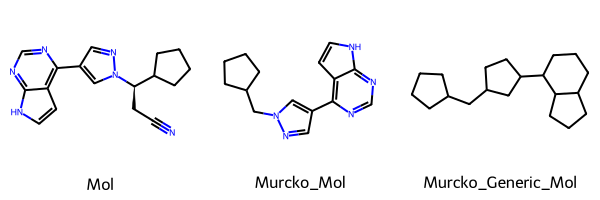

In [14]:
import pandas as pd
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools # PandasToolsをインポート

parent = project
parent_smiles = get_simple_smiles(parent, 'name')

# SMILESをDataFrameに格納
df_parent = pd.DataFrame({'SMILES': [parent_smiles], 'Name': [parent]})

# RDKit Molオブジェクトカラムを追加 (元の分子)
PandasTools.AddMoleculeColumnToFrame(df_parent, smilesCol='SMILES', molCol='Mol', includeFingerprints=False)

# Bemis-Murcko ScaffoldのSMILESカラムとMolオブジェクトカラムを追加
PandasTools.AddMurckoToFrame(df_parent, molCol='Mol', MurckoCol='Murcko_SMILES', Generic=False)
df_parent['Murcko_Mol'] = df_parent['Murcko_SMILES'].apply(Chem.MolFromSmiles)

# Murcko_generic ScaffoldのSMILESカラムとMolオブジェクトカラムを追加
PandasTools.AddMurckoToFrame(df_parent, molCol='Mol', MurckoCol='Murcko_Generic_SMILES', Generic=True)
df_parent['Murcko_Generic_Mol'] = df_parent['Murcko_Generic_SMILES'].apply(Chem.MolFromSmiles)

columns = ['Mol', 'Murcko_Mol', 'Murcko_Generic_Mol']
Draw.MolsToGridImage(df_parent[columns].iloc[0], legends=columns)

all_desc.csvのデータに対してMurcko_Molを発生

In [16]:
# REINVENT4の出力CSVファイルを読み込む
df = pd.read_csv(f'{results_dir}/{parent}_all_desc.csv', sep=',')

# Molオブジェクトカラムを追加
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='SMILES', molCol='Mol', includeFingerprints=False)

# Bemis-Murcko ScaffoldとMurcko_generic ScaffoldのSMILESカラムを追加
PandasTools.AddMurckoToFrame(df, molCol='Mol', MurckoCol='Murcko_SMILES', Generic=False)
PandasTools.AddMurckoToFrame(df, molCol='Mol', MurckoCol='Murcko_Generic_SMILES', Generic=True)

# Molを除いてcsvを保存
df.drop('Mol', axis=1).to_csv(f'{results_dir}/{parent}_murcko.csv', index=False)

# None値が含まれる可能性があるため、エラー回避のためにlambda式で処理
df['Murcko_Mol'] = df['Murcko_SMILES'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)
df['Murcko_Generic_Mol'] = df['Murcko_Generic_SMILES'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)

# 新しく追加されたカラムを含むデータフレームのheadを表示
display(df[['SMILES', 'Mol', 'Murcko_SMILES', 'Murcko_Mol', 'Murcko_Generic_SMILES', 'Murcko_Generic_Mol']].head())

SMILES  \
0       N#CCC(C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
1  N#CC[C@@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
2       N#CCC(C1CCOCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
3         N#CCC(C1CCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
4   N#CC[C@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   

                                             Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x394963f40>   
1  <rdkit.Chem.rdchem.Mol object at 0x39496c040>   
2  <rdkit.Chem.rdchem.Mol object at 0x39496c0b0>   
3  <rdkit.Chem.rdchem.Mol object at 0x39496c120>   
4  <rdkit.Chem.rdchem.Mol object at 0x39496c190>   

                           Murcko_SMILES  \
0  c1nc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1   
1  c1nc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1   
2  c1nc(-c2cnn(CC3CCOCC3)c2)c2cc[nH]c2n1   
3    c1nc(-c2cnn(CC3CCC3)c2)c2cc[nH]c2n1   
4  c1nc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1   

                                      Murcko_Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x3dedf0f20>   
1  <rdkit.Chem.rdchem.Mol object at 0x3dedf1150>   
2  <rdkit.Chem.rdchem.Mol object at 0x3dedf11c0>   
3  <rdkit.Chem.rdchem.Mol object at 0x3dedf1230>   
4  <rdkit.Chem.rdchem.Mol object at 0x3dedf12a0>   

               Murcko_Generic_SMILES  \
0  C1CCC(CC2CCC(C3CCCC4CCCC43)C2)CC1   
1  C1CCC(CC2CCC(C3CCCC4CCCC43)C2)CC1   
2  C1CCC(CC2CCC(C3CCCC4CCCC43)C2)CC1   
3    C1CC(CC2CCC(C3CCCC4CCCC43)C2)C1   
4  C1CCC(CC2CCC(C3CCCC4CCCC43)C2)CC1   

                              Murcko_Generic_Mol  
0  <rdkit.Chem.rdchem.Mol object at 0x3c7e206d0>  
1  <rdkit.Chem.rdchem.Mol object at 0x3c7e20740>  
2  <rdkit.Chem.rdchem.Mol object at 0x3c7e207b0>  
3  <rdkit.Chem.rdchem.Mol object at 0x3c7e20820>  
4  <rdkit.Chem.rdchem.Mol object at 0x3c7e20890>

## Scaffold analysis

Scaffoldの出現頻度をモデルごとに積み上げ棒グラフで描画

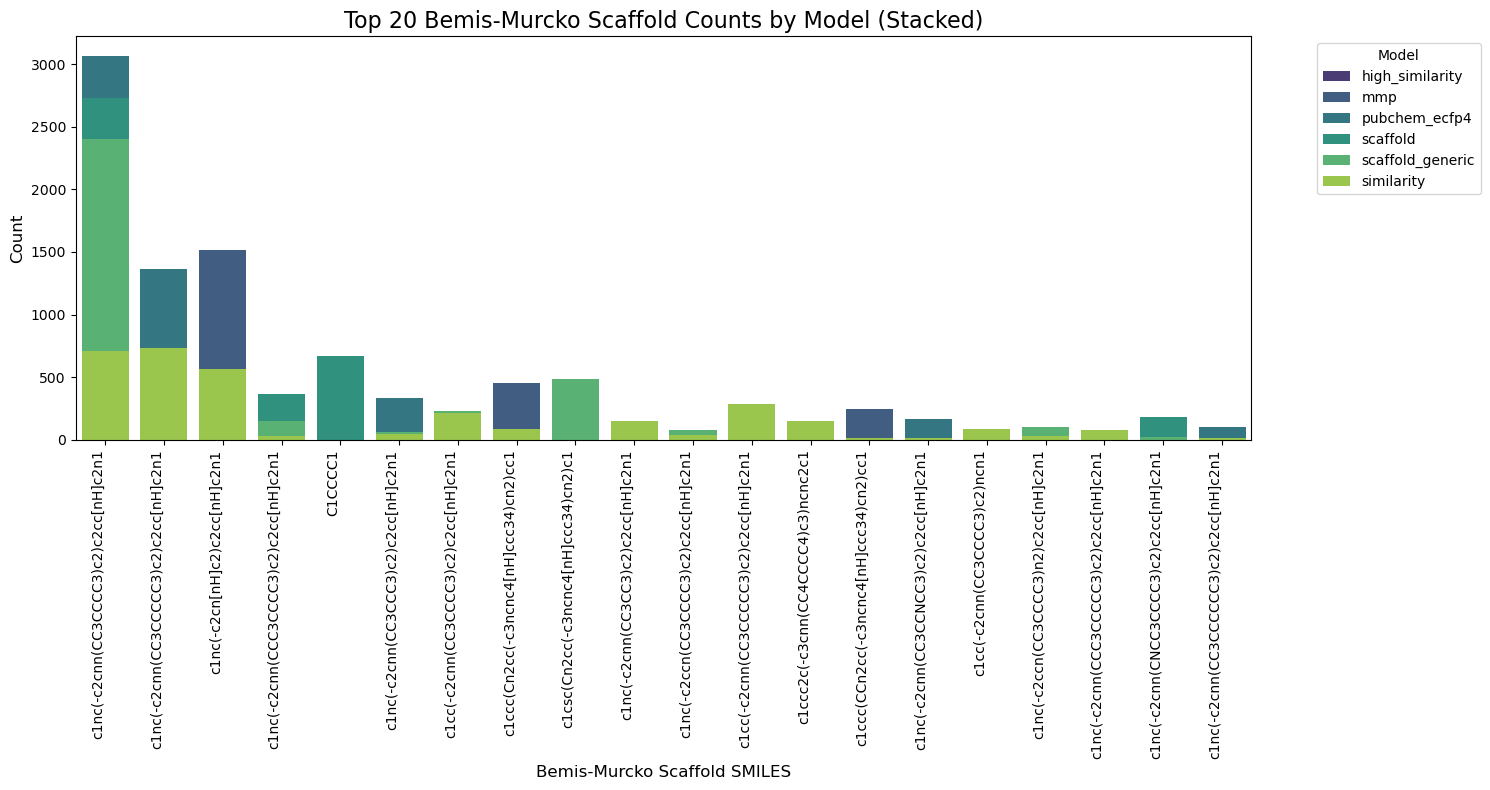


--- Top 20 Bemis-Murcko Scaffold Structures ---


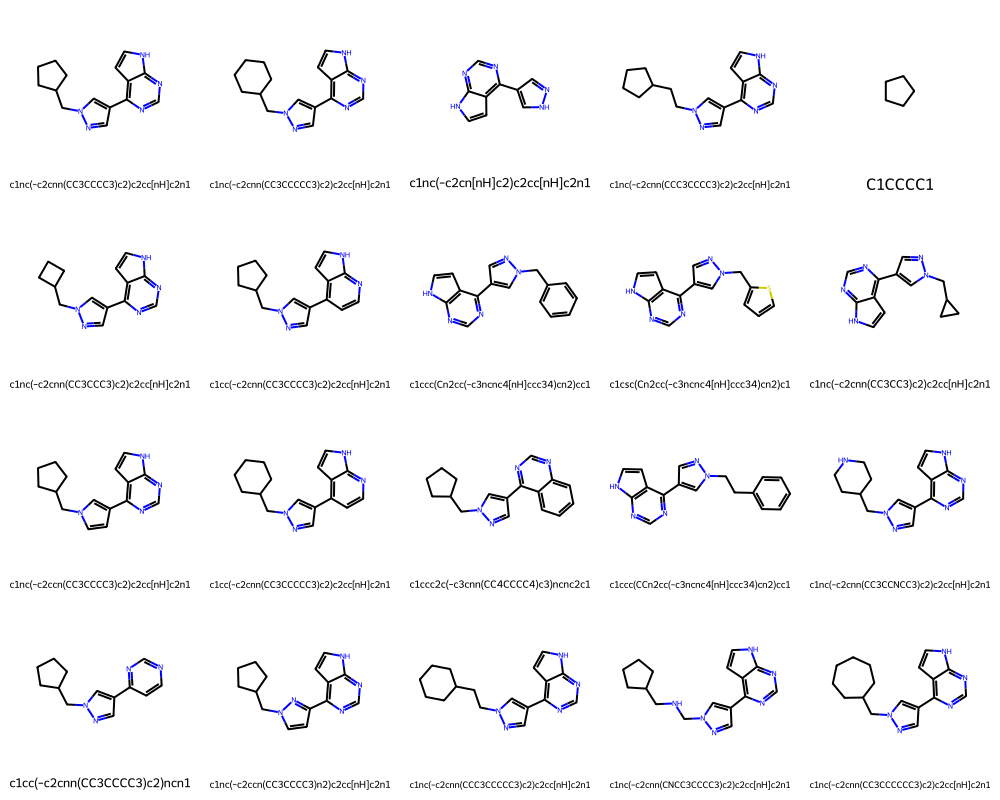

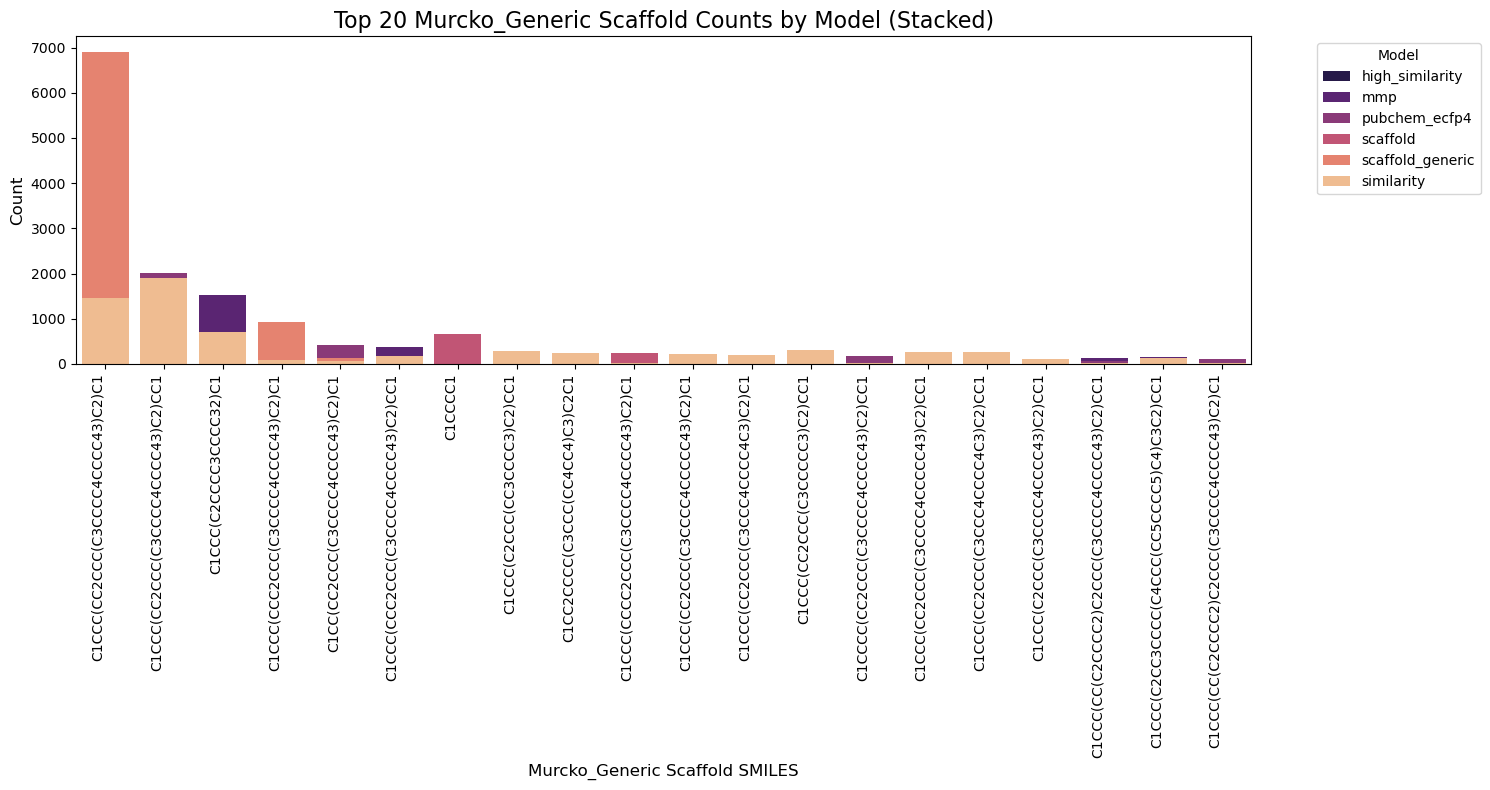


--- Top 20 Murcko_Generic Scaffold Structures ---


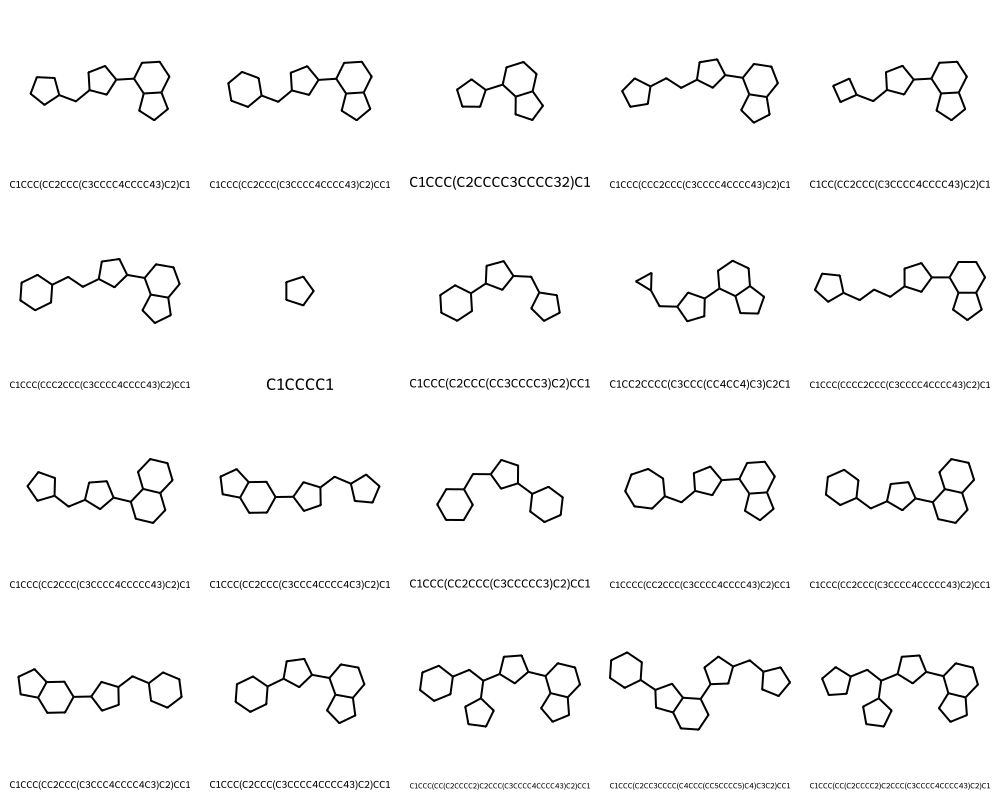

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# --- Bemis-Murcko Scaffoldの頻度とモデルごとの積み上げ棒グラフ ---

# Bemis-Murcko ScaffoldのSMILESとモデルでグループ化し、カウント
bemis_murcko_model_counts = df.groupby(['Murcko_SMILES', 'model']).size().reset_index(name='Count')
bemis_murcko_model_counts = bemis_murcko_model_counts.dropna(subset=['Murcko_SMILES'])

# 全体の出現回数に基づいて上位20の足場を特定
bemis_total_counts_series = bemis_murcko_model_counts.groupby('Murcko_SMILES')['Count'].sum()
top_n_scaffolds_bemis = bemis_total_counts_series.nlargest(20).index.tolist()

# 上位の足場のみにフィルタリングし、ソート順を保持
# .copy() を追加して明示的にコピーを作成
bemis_murcko_model_counts_top = bemis_murcko_model_counts[bemis_murcko_model_counts['Murcko_SMILES'].isin(top_n_scaffolds_bemis)].copy()
bemis_murcko_model_counts_top['Murcko_SMILES'] = pd.Categorical(bemis_murcko_model_counts_top['Murcko_SMILES'], categories=top_n_scaffolds_bemis, ordered=True)
bemis_murcko_model_counts_top = bemis_murcko_model_counts_top.sort_values(['Murcko_SMILES', 'model'])


plt.figure(figsize=(15, 8)) 
sns.barplot(
    data=bemis_murcko_model_counts_top,
    x='Murcko_SMILES',
    y='Count',
    hue='model', 
    palette='viridis',
    dodge=False 
)
plt.title('Top 20 Bemis-Murcko Scaffold Counts by Model (Stacked)', fontsize=16)
plt.xlabel('Bemis-Murcko Scaffold SMILES', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=10) 
plt.yticks(fontsize=10)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()

# Bemis-Murcko Scaffoldの実際の構造を表示
print("\n--- Top 20 Bemis-Murcko Scaffold Structures ---")
top_bemis_mols = [Chem.MolFromSmiles(smi) for smi in top_n_scaffolds_bemis]
display(Draw.MolsToGridImage(top_bemis_mols, legends=top_n_scaffolds_bemis, molsPerRow=5, subImgSize=(200, 200)))


# --- Murcko_Generic Scaffoldの頻度とモデルごとの積み上げ棒グラフ ---

# Murcko_Generic ScaffoldのSMILESとモデルでグループ化し、カウント
generic_murcko_model_counts = df.groupby(['Murcko_Generic_SMILES', 'model']).size().reset_index(name='Count')
generic_murcko_model_counts = generic_murcko_model_counts.dropna(subset=['Murcko_Generic_SMILES'])

# 全体の出現回数に基づいて上位20の足場を特定
generic_total_counts_series = generic_murcko_model_counts.groupby('Murcko_Generic_SMILES')['Count'].sum()
top_n_scaffolds_generic = generic_total_counts_series.nlargest(20).index.tolist()

# 上位の足場のみにフィルタリングし、ソート順を保持
# .copy() を追加して明示的にコピーを作成
generic_murcko_model_counts_top = generic_murcko_model_counts[generic_murcko_model_counts['Murcko_Generic_SMILES'].isin(top_n_scaffolds_generic)].copy()
generic_murcko_model_counts_top['Murcko_Generic_SMILES'] = pd.Categorical(generic_murcko_model_counts_top['Murcko_Generic_SMILES'], categories=top_n_scaffolds_generic, ordered=True)
generic_murcko_model_counts_top = generic_murcko_model_counts_top.sort_values(['Murcko_Generic_SMILES', 'model'])


plt.figure(figsize=(15, 8)) 
sns.barplot(
    data=generic_murcko_model_counts_top,
    x='Murcko_Generic_SMILES',
    y='Count',
    hue='model', 
    palette='magma',
    dodge=False 
)
plt.title('Top 20 Murcko_Generic Scaffold Counts by Model (Stacked)', fontsize=16)
plt.xlabel('Murcko_Generic Scaffold SMILES', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=10) 
plt.yticks(fontsize=10)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()

# Murcko_Generic Scaffoldの実際の構造を表示
print("\n--- Top 20 Murcko_Generic Scaffold Structures ---")
top_generic_mols = [Chem.MolFromSmiles(smi) for smi in top_n_scaffolds_generic]
display(Draw.MolsToGridImage(top_generic_mols, legends=top_n_scaffolds_generic, molsPerRow=5, subImgSize=(200, 200)))

Treemapで骨格の出現頻度をmodelごとに可視化

In [18]:
import pandas as pd
import plotly.express as px # Treemap描画用
# from rdkit import Chem # Treemap描画には直接不要ですが、もし必要ならコメントアウトを外してください
# from rdkit.Chem import PandasTools # Treemap描画には直接不要ですが、もし必要ならコメントアウトを外してください


# --- Bemis-Murcko ScaffoldのTreemap ---
print("\n--- Bemis-Murcko Scaffold Treemap by Model ---")
# モデルと足場SMILESの組み合わせでカウント
# df が既に定義され、'model' と 'Murcko_SMILES' カラムを持つことを前提とします。
bemis_treemap_data = df.groupby(['model', 'Murcko_SMILES']).size().reset_index(name='Count')
bemis_treemap_data = bemis_treemap_data.dropna(subset=['Murcko_SMILES']) # Noneの足場を除外

fig_bemis = px.treemap(
    bemis_treemap_data, 
    path=[px.Constant("All Models"), 'model', 'Murcko_SMILES'], # 階層構造: 全体 -> モデル -> 足場SMILES
    values='Count', 
    title='Bemis-Murcko Scaffold Frequency by Model',
    color='model', # モデルで色分け
    hover_data=['Count'], # ホバー時に表示するデータ
)
fig_bemis.update_traces(root_color="lightgrey") # ルートの色を設定
fig_bemis.update_layout(margin = dict(t=50, l=25, r=25, b=25)) # マージン調整
fig_bemis.show()


# --- Murcko_Generic ScaffoldのTreemap ---
print("\n--- Murcko_Generic Scaffold Treemap by Model ---")
# モデルと足場SMILESの組み合わせでカウント
# df が既に定義され、'model' と 'Murcko_Generic_SMILES' カラムを持つことを前提とします。
generic_treemap_data = df.groupby(['model', 'Murcko_Generic_SMILES']).size().reset_index(name='Count')
generic_treemap_data = generic_treemap_data.dropna(subset=['Murcko_Generic_SMILES']) # Noneの足場を除外

fig_generic = px.treemap(
    generic_treemap_data, 
    path=[px.Constant("All Models"), 'model', 'Murcko_Generic_SMILES'], # 階層構造: 全体 -> モデル -> 足場SMILES
    values='Count', 
    title='Murcko_Generic Scaffold Frequency by Model',
    color='model', # モデルで色分け
    hover_data=['Count'], # ホバー時に表示するデータ
)
fig_generic.update_traces(root_color="lightgrey")
fig_generic.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig_generic.show()


--- Bemis-Murcko Scaffold Treemap by Model ---



--- Murcko_Generic Scaffold Treemap by Model ---


top 30 scaffoldsを円グラフで解析

In [19]:
import pandas as pd
import plotly.express as px

# df が既に定義され、
# 'model', 'Murcko_SMILES', 'Murcko_Generic_SMILES' カラムを持つことを前提とします。

# 全てのモデル名を取得
all_models = sorted(df['model'].unique())
all_scaffold_types = ['Bemis-Murcko', 'Murcko-Generic'] # 表示順序を固定

# 各モデル、各足場タイプごとにTop NとOthersをまとめる関数
def process_scaffold_data_for_pie(df, scaffold_smi_col, top_n=30):
    processed_data = []
    
    temp_df = df[['model', scaffold_smi_col]].copy()
    temp_df = temp_df.dropna(subset=[scaffold_smi_col])

    for model_name in temp_df['model'].unique():
        model_subset = temp_df[temp_df['model'] == model_name].copy()
        counts = model_subset[scaffold_smi_col].value_counts().reset_index()
        counts.columns = ['Scaffold_SMILES', 'Count'] 
        
        if len(counts) > top_n:
            top_n_scaffolds = counts.head(top_n)
            others_count = counts.iloc[top_n:]['Count'].sum()
            pie_data_entry = pd.concat([top_n_scaffolds, pd.DataFrame([{'Scaffold_SMILES': 'Others', 'Count': others_count}])])
        else:
            pie_data_entry = counts
        
        pie_data_entry['model'] = model_name
        processed_data.append(pie_data_entry)
        
    return pd.concat(processed_data).reset_index(drop=True)

# Bemis-Murcko Scaffoldの円グラフデータ処理
bemis_pie_data_processed = process_scaffold_data_for_pie(df, 'Murcko_SMILES', top_n=30)
bemis_pie_data_processed['Scaffold_Type'] = 'Bemis-Murcko'

# Murcko_Generic Scaffoldの円グラフデータ処理
generic_pie_data_processed = process_scaffold_data_for_pie(df, 'Murcko_Generic_SMILES', top_n=30)
generic_pie_data_processed['Scaffold_Type'] = 'Murcko-Generic'

# 両方のデータを結合
combined_pie_data = pd.concat([bemis_pie_data_processed, generic_pie_data_processed])

# ファセット円グラフの描画
fig = px.pie(
    combined_pie_data, 
    values='Count', 
    names='Scaffold_SMILES', 
    facet_col='model', 
    facet_row='Scaffold_Type', 
    title='Top 30 Scaffold Distribution by Model and Scaffold Type (Pie Charts)',
    hole=0.4, 
    # color='Scaffold_Type', # この行を削除することで、namesによって直接色分けされる
    category_orders={"model": all_models, "Scaffold_Type": all_scaffold_types}, 
    height=800, 
    hover_data=['Count']
)

# 各円グラフのテキスト表示を調整
fig.update_traces(textposition='inside', textinfo='percent') 
fig.update_layout(
    title_font_size=20,
    # 凡例の設定をより詳細に調整し、多くの色が表示されるようにする
    legend_title_text='Scaffold SMILES', # 凡例のタイトルをより具体的に
    legend=dict(
        orientation="v", # 垂直方向に並べる
        yanchor="top", # 上揃え
        y=1, # 上端に配置
        xanchor="left", # 左揃え
        x=1.02, # グラフの右外側に配置
        font=dict(size=8) # 凡例のフォントサイズを小さく
    ),
    margin=dict(r=200) # 右マージンを増やして凡例スペースを確保
)

# サブプロットのタイトルを調整
fig.for_each_annotation(lambda a: a.update(text=f"Model: {a.text.split('model=')[-1].split('|')[0].strip()} <br> Type: {a.text.split('Scaffold_Type=')[-1].strip()}"))

fig.show()

## MMP analysis

1. 既存分子からのMurcko Scaffoldと側鎖の抽出  
目的: まずはdf（生成分子または既知の化合物ライブラリ）から、頻繁に出現する代表的なMurcko Scaffoldと、それに結合している様々な側鎖を抽出。

2. 側鎖ライブラリの構築
目的: 抽出した側鎖の中から、生成に利用可能なユニークな側鎖の「ライブラリ」を構築。

3. 代表的なMurcko Scaffoldの選定
目的: 全ての足場を対象にするのは非効率的なので、解析対象として特に興味深い、または生成モデルが頻繁に生成する代表的な足場をいくつか選択。

4. 足場と側鎖の結合による新規分子の生成
目的: 選定した足場に、構築した側鎖ライブラリから側鎖を結合させて、新しい「MMP風」の分子を系統的に生成。

5. 生成分子の特性値計算と可視化
目的: 生成された各新規分子について物性記述子や予測活性値を計算し、足場-側鎖の組み合わせと特性値の関係を分析。

データのロード

In [2]:
import pandas as pd
import os
import glob
from rdkit import Chem

cwd = os.getcwd()
user = 'keetane'
project = 'ruxolitinib'
wd = os.path.join(cwd, '1_wd', user, project)
input_dir    = os.path.join(wd, 'input');    os.makedirs(input_dir, exist_ok=True)
results_dir  = os.path.join(wd, 'results');  os.makedirs(results_dir, exist_ok=True)
results_log  = os.path.join(results_dir, 'log');  os.makedirs(results_log, exist_ok=True)
toml_dir     = os.path.join(wd, 'toml');     os.makedirs(toml_dir, exist_ok=True)
toml_path = os.path.join(toml_dir, "sampling.toml")
sampling_log = os.path.join(results_dir, 'log'); os.makedirs(sampling_log, exist_ok=True)

df = pd.read_csv(f'{results_dir}/{project}_murcko.csv')
df['Mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)
df['Murcko_Mol'] = df['Murcko_SMILES'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)
df['Murcko_Generic_Mol'] = df['Murcko_Generic_SMILES'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)
df.columns

Index(['SMILES', 'Input_SMILES', 'Tanimoto', 'NLL', 'model', 'MW', 'LogP',
       'TPSA', 'HBA', 'HBD', 'Rotatable_Bonds', 'Amide_Count', 'Ring_Count',
       'Aromatic_Ring_Count', 'Fraction_CSP3', 'NumChiralCenters',
       'Murcko_SMILES', 'Murcko_Generic_SMILES', 'Mol', 'Murcko_Mol',
       'Murcko_Generic_Mol'],
      dtype='object')

1. 側鎖の抽出

In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem # AllChemモジュールを使用
from rdkit.Chem.rdMMPA import FragmentMol # 今回は使用しないが、以前の経緯で残しておく
from collections import defaultdict
import os
import sys

print("--- Step 1: Extracting Murcko Scaffolds and Attached Side Chains (Revised) ---")

# 新しいアプローチ: 元の分子からMurcko Scaffoldを除去してサイドチェーンを得る
def get_side_chain_by_replacing_murcko(original_mol, murcko_mol, original_smiles):
    if original_mol is None or murcko_mol is None:
        return None, None # 無効な分子はスキップ

    # Try to find the Murcko Scaffold as a substructure within the original molecule
    if not original_mol.HasSubstructMatch(murcko_mol):
        return None, None

    # Murcko Scaffold部分をダミー原子（*）で置き換え
    replaced_mols = AllChem.ReplaceSubstructs(original_mol, murcko_mol, Chem.MolFromSmiles('*'), replaceAll=True)

    if not replaced_mols:
        return None, None # 置換できなかった場合

    # 置換後の分子（サイドチェーン）を取得
    # 通常、Murckoは一つのはずだが、念のため
    side_chain_mol = replaced_mols[0]
    
    # サイドチェーンのSMILESを取得
    side_chain_smiles = Chem.MolToSmiles(side_chain_mol, isomericSmiles=True)
    
    # ダミー原子（アタッチメントポイント）の数を数える
    attachment_point_count = side_chain_smiles.count('*')

    return side_chain_smiles, attachment_point_count


# 各分子からMurcko Scaffoldと対応するサイドチェーンを抽出
all_scaffold_side_chains = []

total_mols = len(df)
print(f"Processing {total_mols} molecules to extract Murcko Scaffolds and Side Chains...")

for index, row in df.iterrows():
    if index % 1000 == 0:
        print(f"\r  Processed {index}/{total_mols} molecules...", end='')
        sys.stdout.flush()

    original_mol = row['Mol']
    murcko_mol = row['Murcko_Mol']
    murcko_smiles = row['Murcko_SMILES'] # 後でデータに含めるため

    # 無効な分子はスキップ
    if original_mol is None or murcko_mol is None or pd.isna(murcko_smiles):
        continue

    # 新しい関数でサイドチェーンを抽出
    side_chain_smi, attachment_point_count = get_side_chain_by_replacing_murcko(
        original_mol, murcko_mol, row['SMILES'] # original_smilesも渡す
    )
    
    if side_chain_smi is not None:
        all_scaffold_side_chains.append({
            'Original_SMILES': row['SMILES'], # 元のSMILESをそのまま含める
            'Murcko_SMILES': murcko_smiles,
            'Side_Chain_SMILES': side_chain_smi,
            'Attachment_Point_Count': attachment_point_count
        })

# ループ終了後、最後の進捗表示を完全な行として表示するため、最後に改行する
print(f"\r  Processed {total_mols}/{total_mols} molecules. Done.", end='\n')


# 抽出したデータをDataFrameに変換
scaffold_side_chain_df = pd.DataFrame(all_scaffold_side_chains)

print("\n--- Extraction Complete ---")
print(f"Total unique Murcko-Scaffold/Side-Chain pairs extracted: {len(scaffold_side_chain_df.drop_duplicates(subset=['Murcko_SMILES', 'Side_Chain_SMILES']))}")
print(f"Total entries (including duplicates for original molecules): {len(scaffold_side_chain_df)}")
print("\nFirst 5 rows of the extracted data:")

--- Step 1: Extracting Murcko Scaffolds and Attached Side Chains (Revised) ---
Processing 49857 molecules to extract Murcko Scaffolds and Side Chains...
  Processed 49857/49857 molecules. Done.

--- Extraction Complete ---
Total unique Murcko-Scaffold/Side-Chain pairs extracted: 23701
Total entries (including duplicates for original molecules): 49810

First 5 rows of the extracted data:


念の為、確認

In [4]:
scaffold_side_chain_df

Original_SMILES  \
0              N#CCC(C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
1         N#CC[C@@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
2              N#CCC(C1CCOCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
3                N#CCC(C1CCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
4          N#CC[C@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
...                                                  ...   
49805  CC(C)CS(=O)(=O)NC[C@H](C1CCCC1)n1ncc(-c2ncnc3[...   
49806  N#CC[C@H](C1CCCCC1)n1ccc(-c2ncnc3[nH]c(-c4ccc(...   
49807  Cc1ccc(S(=O)(=O)n2cc(-c3cnn(C(CC#N)C4CCCC4)c3)...   
49808  CS(=O)(=O)NC(=O)CCC(C1CCCC1)n1ccc(-c2ccnc3[nH]...   
49809  CS(=O)(=O)NC(=O)CC(C1CCCCC1)n1ncc(-c2ccnc3[nH]...   

                                          Murcko_SMILES  \
0                 c1nc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1   
1                 c1nc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1   
2                 c1nc(-c2cnn(CC3CCOCC3)c2)c2cc[nH]c2n1   
3                   c1nc(-c2cnn(CC3CCC3)c2)c2cc[nH]c2n1   
4                 c1nc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1   
...                                                 ...   
49805              c1nc(-c2cnn(CC3CCCC3)c2)c2cc[nH]c2n1   
49806  c1ccc(-c2cc3c(-c4ccn(CC5CCCCC5)c4)ncnc3[nH]2)cc1   
49807      O=S(=O)(c1ccccc1)n1cc(-c2cnn(CC3CCCC3)c2)cn1   
49808              c1cc(-c2ccn(CC3CCCC3)c2)c2cc[nH]c2n1   
49809             c1cc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1   

            Side_Chain_SMILES  Attachment_Point_Count  
0                      *.CC#N                       1  
1                      *.CC#N                       1  
2                      *.CC#N                       1  
3                      *.CC#N                       1  
4                      *.CC#N                       1  
...                       ...                     ...  
49805  *.CNS(=O)(=O)CC(C)C.CO                       1  
49806        *S(N)(=O)=O.CC#N                       1  
49807                *.C.CC#N                       1  
49808    *.CCC(=O)NS(C)(=O)=O                       1  
49809  *.Br.CC(=O)NS(C)(=O)=O                       1  

[49810 rows x 4 columns]

2. 側鎖ライブラリの構築

--- Step 2: Building the Side Chain Library ---
Total unique side chains extracted: 5221

First 10 unique side chains:
   Side_Chain_SMILES  Attachment_Point_Count
0             *.CC#N                       1
7            *.CCC#N                       1
8          *.CC(N)=O                       1
19          *.CC(C)C                       1
23       *.CC(C)(C)O                       1
24        *.CC(C)C#N                       1
27              *.CC                       1
30     *.CS(C)(=O)=O                       1
31            *.CCOC                       1
34          *.CC#N.F                       1

--- Distribution of Attachment Point Counts for Unique Side Chains ---
Attachment_Point_Count
1    5221
Name: count, dtype: int64

--- Examples of Side Chains with 1 Attachment Point (First 5) ---


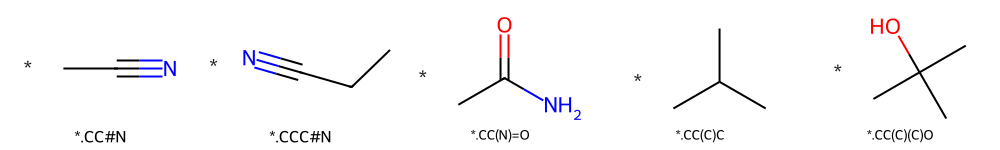


--- Side Chain Library Building Complete ---


In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, Image

print("--- Step 2: Building the Side Chain Library ---")

# 1. ユニークな側鎖SMILESの抽出
unique_side_chains = scaffold_side_chain_df.drop_duplicates(subset=['Side_Chain_SMILES'])

# Side Chain SMILES とその Attachment_Point_Count を含むDataFrameを作成
# drop_duplicates() を使った時点で、各 Side_Chain_SMILES に対応する最初の Attachment_Point_Count が残る
side_chain_library_df = unique_side_chains[['Side_Chain_SMILES', 'Attachment_Point_Count']].copy()

# もし、同じ Side_Chain_SMILES でも Attachment_Point_Count が異なるケースがあれば、ここで考慮する必要がある
print(f"Total unique side chains extracted: {len(side_chain_library_df)}")
print("\nFirst 10 unique side chains:")
print(side_chain_library_df.head(10))


# 2. 結合手（アタッチメントポイント）ごとの側鎖の数を集計
attachment_point_counts = side_chain_library_df['Attachment_Point_Count'].value_counts().sort_index()

print("\n--- Distribution of Attachment Point Counts for Unique Side Chains ---")
print(attachment_point_counts)

# (オプション) 最も一般的な結合手を持つ側鎖の例をいくつか表示する
if 1 in attachment_point_counts.index:
    print("\n--- Examples of Side Chains with 1 Attachment Point (First 5) ---")
    one_attachment_side_chains = side_chain_library_df[side_chain_library_df['Attachment_Point_Count'] == 1].head(5)
    
    mols_to_draw = []
    legends = []
    for idx, row in one_attachment_side_chains.iterrows():
        mol = Chem.MolFromSmiles(row['Side_Chain_SMILES'])
        if mol:
            mols_to_draw.append(mol)
            legends.append(row['Side_Chain_SMILES'])
            
    if mols_to_draw:
        img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(200, 150), legends=legends)
        display(img)
    else:
        print("No valid 1-attachment side chains to draw.")

print("\n--- Side Chain Library Building Complete ---")

# side_chain_library_df は次のステップで利用できるよう保持されます。

3. 代表的なMurcko Scaffoldの選定

--- Step 3: Selecting Representative Murcko Scaffolds (修正版) ---

--- Top Most Frequent Murcko Scaffolds (Filtered) ---
Murcko_SMILES
c1nc(-c2cnn(CC3CCCC3)c2)c2cc[nH]c2n1     11985
c1nc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1     3337
c1nc(-c2cn[nH]c2)c2cc[nH]c2n1             2868
c1nc(-c2cnn(CCC3CCCC3)c2)c2cc[nH]c2n1      891
c1nc(-c2cnn(CC3CCC3)c2)c2cc[nH]c2n1        680
c1cc(-c2cnn(CC3CCCC3)c2)c2cc[nH]c2n1       623
c1ccc(Cn2cc(-c3ncnc4[nH]ccc34)cn2)cc1      557
c1csc(Cn2cc(-c3ncnc4[nH]ccc34)cn2)c1       521
c1nc(-c2cnn(CC3CC3)c2)c2cc[nH]c2n1         390
c1nc(-c2ccn(CC3CCCC3)c2)c2cc[nH]c2n1       368
Name: count, dtype: int64

--- Visualizing Top Murcko Scaffolds (Filtered) ---


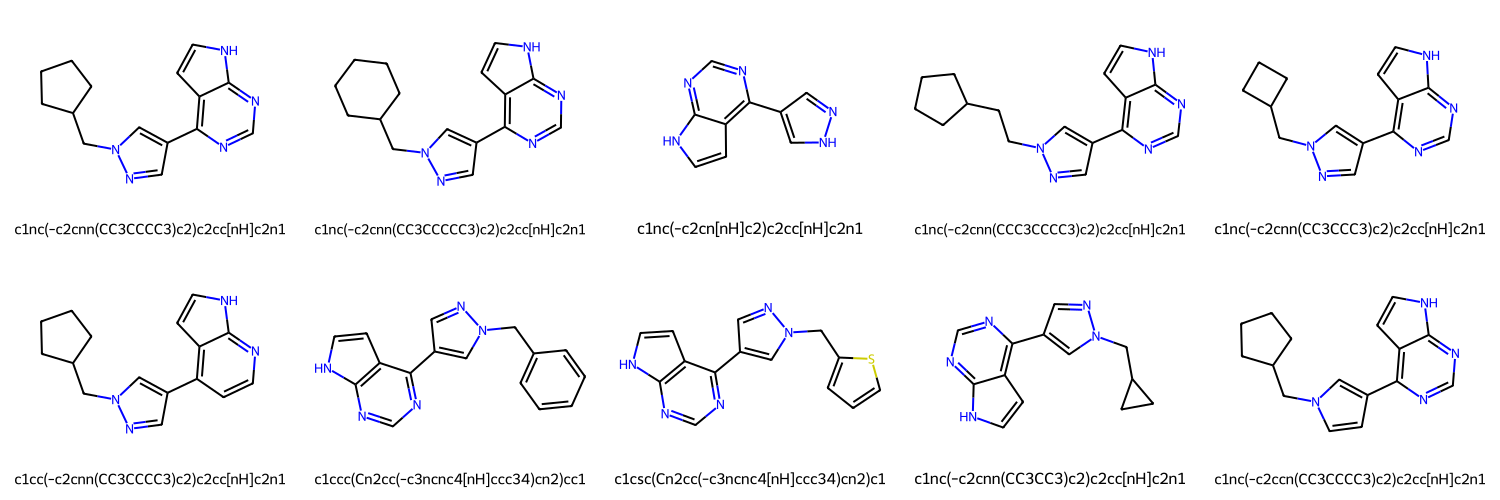


--- Murcko Scaffold Selection Complete ---
Selected 10 top Murcko Scaffolds for further analysis after filtering.


In [6]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, Image
from collections import Counter
import warnings

warnings.filterwarnings('ignore') # プロット時の警告を非表示にすることがあります

# df と scaffold_side_chain_df が既に存在することを前提とします。
# もし df に Murcko_SMILES カラムがない場合は、以前のステップで計算し直す必要があります。

print("--- Step 3: Selecting Representative Murcko Scaffolds (修正版) ---")

# --- 設定 ---
# 上位のMurcko Scaffoldの表示数
NUM_TOP_SCAFFOLDS = 10 

# **新しい設定:** 足場として認識したくない、単純すぎるSMILESのリスト
# これらは「側鎖」としてのみ扱われるべきと考えるSMILESです。
EXCLUDE_SCAFFOLDS_FROM_TOP_LIST = {
    'C1CCCC1',  # シクロペンタン環
    'C1CCCCC1', # シクロヘキサン環 (もしあれば、同様に除外したい場合)
    'C1CCC1',   # シクロブタン環
    'C1CC1',    # シクロプロパン環
    'c1ccccc1', # ベンゼン環 (もしこれを「側鎖」と見なしたい場合)
    # 必要に応じて追加
}
# -----------------

# 1. Murcko Scaffoldの頻度を計算
if 'Murcko_SMILES' in df.columns: # dfにMurcko_SMILESがあることを確認
    murcko_scaffold_counts = df['Murcko_SMILES'].value_counts()
else:
    # ここにMurcko Scaffoldを計算するロジックを再度記述するか、
    # dfにMurcko_SMILESカラムが事前に計算されていることを確認してください。
    # 例:
    # from rdkit.Chem.Scaffolds import MurckoScaffold
    # df['Murcko_Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)
    # df['Murcko_SMILES'] = df['Murcko_Mol'].apply(lambda x: Chem.MolToSmiles(MurckoScaffold.Get={}MurckoScaffold(x)) if x else None)
    print("Error: 'Murcko_SMILES' column not found in df. Please ensure Murcko Scaffolds are calculated first.")
    # プロセスを中断するか、適切なエラーハンドリングを行う

# 2. 除外リストに含まれるMurcko Scaffoldをフィルタリング
filtered_scaffold_counts = murcko_scaffold_counts[
    ~murcko_scaffold_counts.index.isin(EXCLUDE_SCAFFOLDS_FROM_TOP_LIST)
]

# 3. 上位N個のMurcko Scaffoldを選定
top_scaffolds_smiles = filtered_scaffold_counts.head(NUM_TOP_SCAFFOLDS).index.tolist()

print("\n--- Top Most Frequent Murcko Scaffolds (Filtered) ---")
print(filtered_scaffold_counts.head(NUM_TOP_SCAFFOLDS))

# 4. 選定されたMurcko Scaffoldの可視化
print("\n--- Visualizing Top Murcko Scaffolds (Filtered) ---")
mols_to_draw = []
legends = []

for smi in top_scaffolds_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        mols_to_draw.append(mol)
        legends.append(smi)

if mols_to_draw:
    # グリッド画像を生成
    img = Draw.MolsToGridImage(
        mols_to_draw,
        molsPerRow=min(len(mols_to_draw), 5), # 1行あたりの分子数
        legends=legends,
        subImgSize=(300, 250) # 各分子画像のサイズ
    )
    display(img)
else:
    print("No valid Murcko Scaffolds to display after filtering.")

print("\n--- Murcko Scaffold Selection Complete ---")
print(f"Selected {len(top_scaffolds_smiles)} top Murcko Scaffolds for further analysis after filtering.")

# top_scaffolds_smiles が更新されたので、次のステップ（Sankey Diagramなど）で利用できます。

4. 足場と側鎖の結合による新規分子の生成

In [7]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, Image
from tqdm.notebook import tqdm # 進捗バーを表示するためにtqdmをインポート

# top_scaffolds_smiles と side_chain_library_df, scaffold_side_chain_df が
# 既に生成されていることを前提とします。
# また、元のdf（MW, LogPなどのプロパティを持つ）も利用できる必要があります。

# --- 設定 ---
# 分析対象とする上位Murcko Scaffoldの数
NUM_SCAFFOLDS_TO_ANALYZE = 5 
# -----------------

print("--- Step 4: Preparing Data for Murcko Scaffold-Side Chain Analysis ---")

# 1. 分析対象のMurcko Scaffoldを絞り込む
# top_scaffolds_smiles は前のステップで計算済み
selected_murcko_scaffolds = top_scaffolds_smiles[:NUM_SCAFFOLDS_TO_ANALYZE]

print(f"Analyzing molecules associated with the top {len(selected_murcko_scaffolds)} Murcko Scaffolds.")

# 2. scaffold_side_chain_df から、選定したMurcko Scaffoldを持つ行を抽出
# Original_SMILES, Murcko_SMILES, Side_Chain_SMILES が含まれる
analysis_df_base = scaffold_side_chain_df[
    scaffold_side_chain_df['Murcko_SMILES'].isin(selected_murcko_scaffolds)
].copy()

# 3. 元のdfから、SMILESに対応するプロパティ（MW, LogP, TPSAなど）をマージする
# これはMMP-likeな分析において、特性の変化を見るために非常に重要です。
# Original_SMILES をキーとしてマージします。
properties_to_merge = [
    'SMILES', 'MW', 'LogP', 'TPSA', 'HBA', 'HBD',
    'Rotatable_Bonds', 'Amide_Count', 'Ring_Count',
    'Aromatic_Ring_Count', 'Fraction_CSP3', 'NumChiralCenters'
] # df に含まれる適切なプロパティを選択

# 元のdfから必要なSMILESとプロパティだけを抽出して準備
original_mol_properties_df = df[properties_to_merge].copy()
original_mol_properties_df = original_mol_properties_df.rename(columns={'SMILES': 'Original_SMILES'})

# マージを実行
# analysis_df_base にプロパティを結合
final_analysis_df = pd.merge(
    analysis_df_base,
    original_mol_properties_df,
    on='Original_SMILES',
    how='left' # 左結合で、ベースのデータフレームにプロパティを追加
)

# 重複するOriginal_SMILES-Murcko_SMILES-Side_Chain_SMILESペアがある場合は、代表行を残す
# (ただし、scaffold_side_chain_df の生成ロジックにより、ここでの重複はあまりないはず)
final_analysis_df.drop_duplicates(
    subset=['Original_SMILES', 'Murcko_SMILES', 'Side_Chain_SMILES'], 
    inplace=True
)

print("\n--- Data Preparation Complete ---")
print(f"Prepared {len(final_analysis_df)} molecules for detailed analysis.")
print("\nFirst 5 rows of the prepared analysis DataFrame:")
print(final_analysis_df.head())

# final_analysis_df は次のステップで利用できるよう保持されます。

--- Step 4: Preparing Data for Murcko Scaffold-Side Chain Analysis ---
Analyzing molecules associated with the top 5 Murcko Scaffolds.

--- Data Preparation Complete ---
Prepared 14905 molecules for detailed analysis.

First 5 rows of the prepared analysis DataFrame:
                                   Original_SMILES  \
0        N#CCC(C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
4   N#CC[C@@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
8          N#CCC(C1CCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
13   N#CC[C@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
17   N#CC[C@@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   

                            Murcko_SMILES Side_Chain_SMILES  \
0   c1nc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1            *.CC#N   
4   c1nc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1            *.CC#N   
8     c1nc(-c2cnn(CC3CCC3)c2)c2cc[nH]c2n1            *.CC#N   
13  c1nc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1            *.CC#N   
17   c1nc(-c2cnn(CC3CCCC3)c2)c2cc[nH]c2n1            *.CC#N   

    Attachment_Point_Count  

5. 生成分子の特性値計算と可視化

--- Step 5: Analyzing Properties for Scaffold: c1nc(-c2cnn(CC3CCCC3)c2)c2cc[nH]c2n1 ---
Found 8770 molecules with scaffold: c1nc(-c2cnn(CC3CCCC3)c2)c2cc[nH]c2n1
Unique side chains for this scaffold: 2734

--- Visualizing Property Distributions per Side Chain for Target Scaffold ---

Property: MW


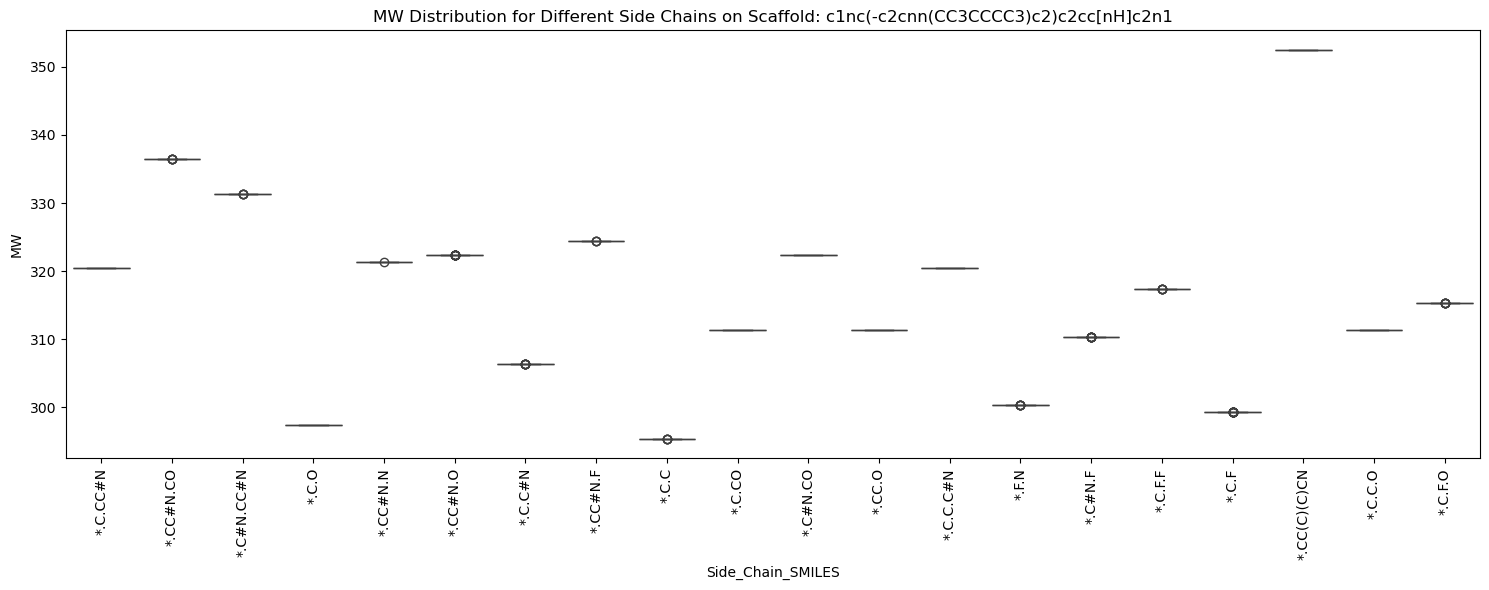


Property: LogP


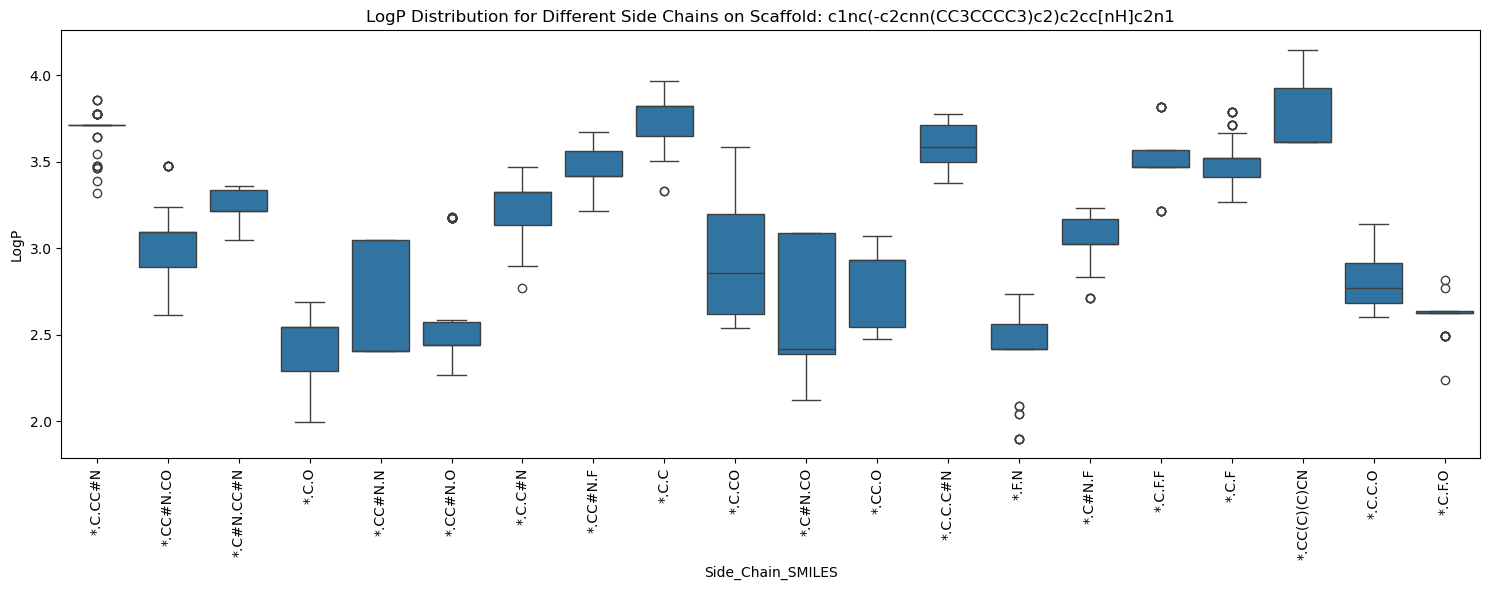


Property: TPSA


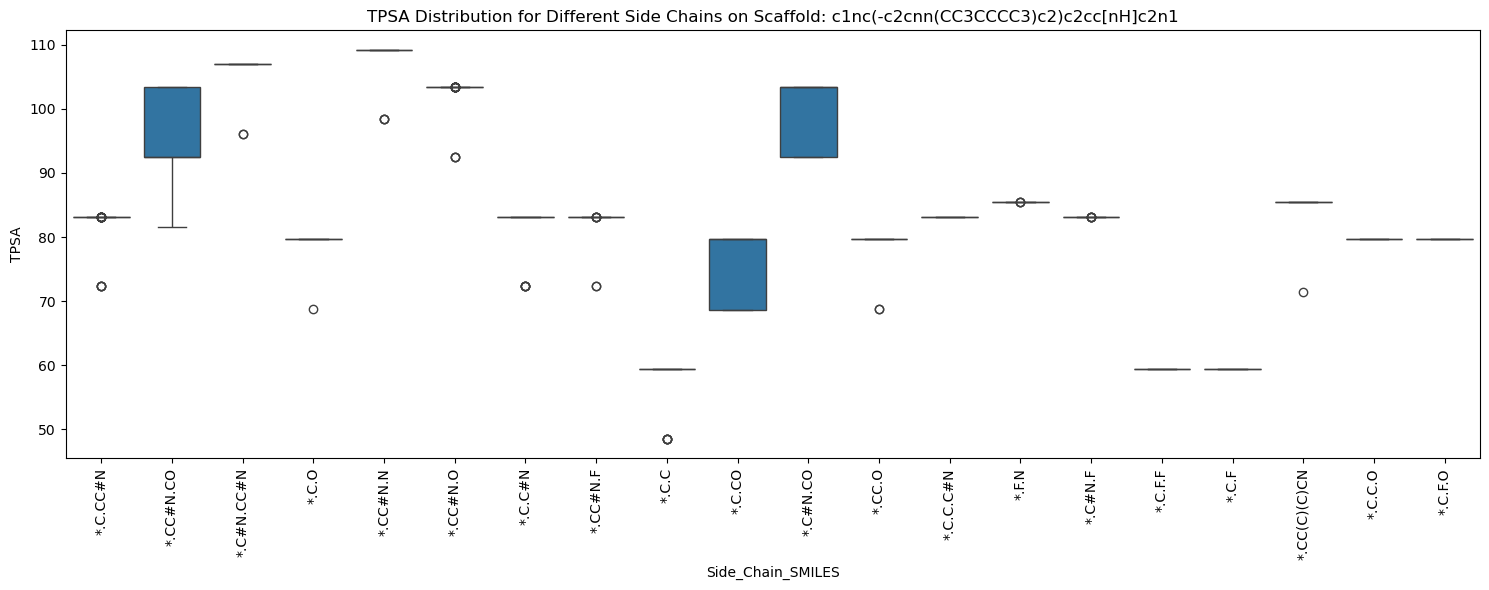


Property: HBA


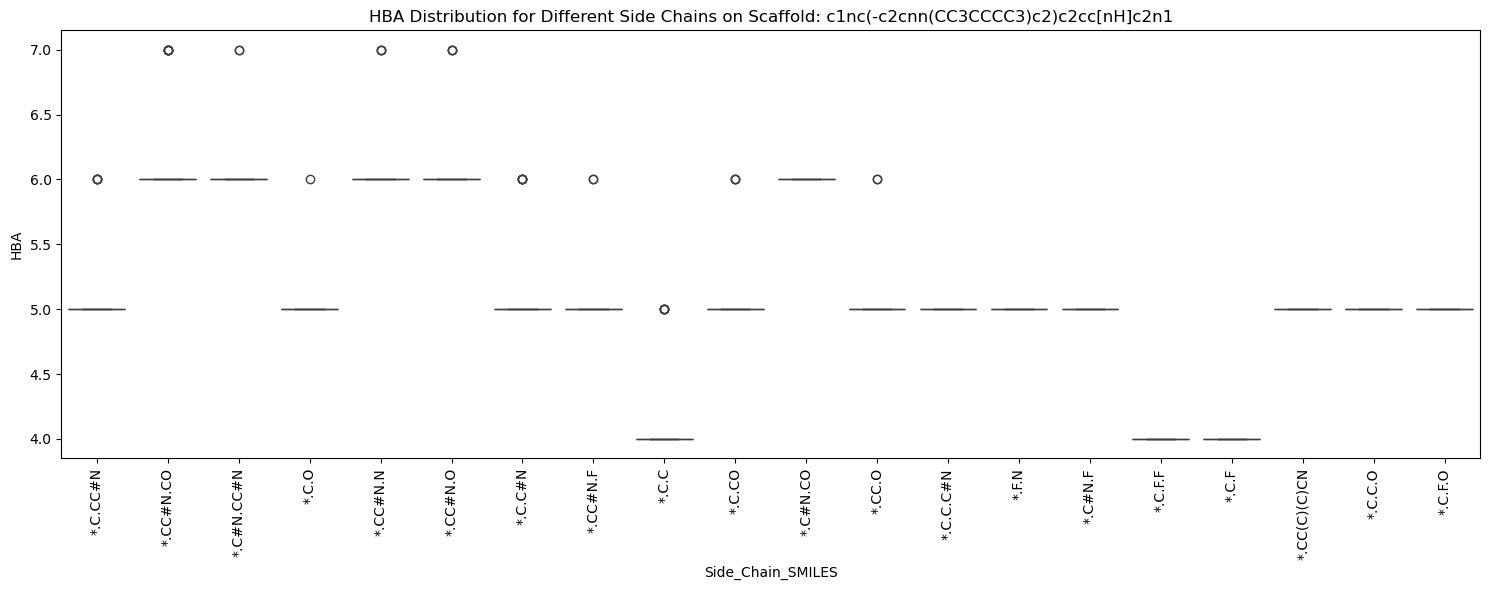


Property: HBD


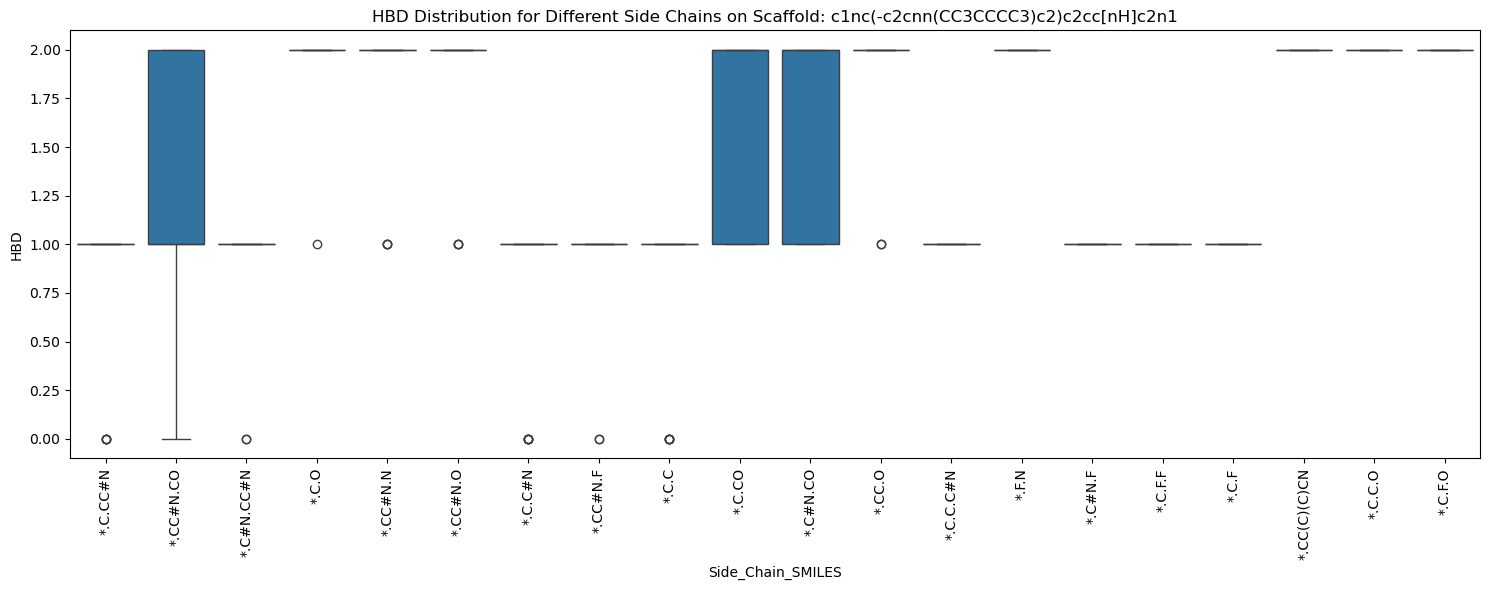


--- Visualizing Representative Molecules and Properties ---


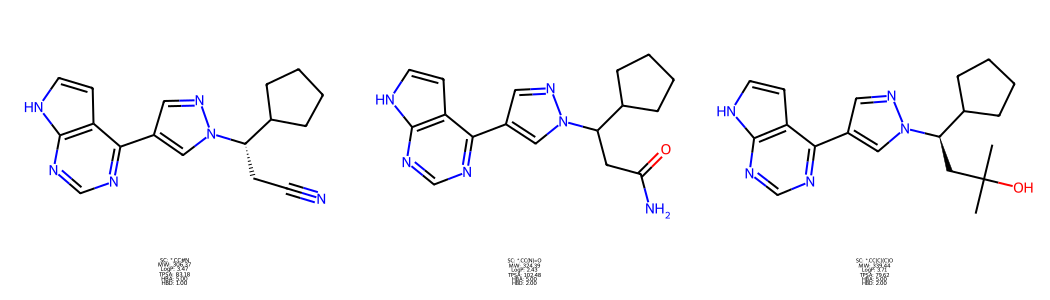


--- MMP-like Analysis Complete ---
You now have a structured way to analyze how different side chains affect properties when attached to a specific Murcko Scaffold.


In [10]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns # より美しいグラフのためにseabornをインポート

# final_analysis_df が既に生成されていることを前提とします。

# --- 設定 ---
# 分析対象とするMurcko ScaffoldのSMILES (例: top_scaffolds_smiles の最初のもの)
# もし特定のSMILESを指定したい場合は直接記述
TARGET_SCAFFOLD_SMILES = top_scaffolds_smiles[0] if top_scaffolds_smiles else None

# 可視化する物性記述子のリスト
PROPERTIES_TO_VISUALIZE = ['MW', 'LogP', 'TPSA', 'HBA', 'HBD'] # df に含まれるものから選択
# 各足場について表示するサイドチェーンのSMILESの例の最大数 (箱ひげ図などで多すぎると表示しきれないため)
MAX_SIDE_CHAINS_FOR_PROPERTY_PLOT = 20 
# 各サイドチェーンの例に対して表示する分子構造のペア数
NUM_MOLS_TO_DRAW_PER_SIDE_CHAIN_EXAMPLE = 3
# -----------------

if TARGET_SCAFFOLD_SMILES is None:
    print("No target scaffold SMILES available. Please ensure 'top_scaffolds_smiles' is populated.")
else:
    print(f"--- Step 5: Analyzing Properties for Scaffold: {TARGET_SCAFFOLD_SMILES} ---")

    # 1. 特定の足場を持つ分子群を抽出
    scaffold_specific_df = final_analysis_df[
        final_analysis_df['Murcko_SMILES'] == TARGET_SCAFFOLD_SMILES
    ].copy()

    if scaffold_specific_df.empty:
        print(f"No molecules found for the target scaffold: {TARGET_SCAFFOLD_SMILES}")
    else:
        print(f"Found {len(scaffold_specific_df)} molecules with scaffold: {TARGET_SCAFFOLD_SMILES}")
        print(f"Unique side chains for this scaffold: {len(scaffold_specific_df['Side_Chain_SMILES'].unique())}")

        # 各サイドチェーンSMILESの出現頻度をカウント
        side_chain_counts = scaffold_specific_df['Side_Chain_SMILES'].value_counts()

        # 物性値の可視化
        print("\n--- Visualizing Property Distributions per Side Chain for Target Scaffold ---")

        # 側鎖のSMILESが長い場合、グラフのX軸が見づらくなるため、頻度の高いものから選択
        top_side_chains_for_plot = side_chain_counts.head(MAX_SIDE_CHAINS_FOR_PROPERTY_PLOT).index.tolist()

        # プロパティごとにプロットを生成
        for prop in PROPERTIES_TO_VISUALIZE:
            if prop in scaffold_specific_df.columns:
                print(f"\nProperty: {prop}")
                
                # プロット用のDataFrameを準備 (選択された上位側鎖のみ)
                plot_df = scaffold_specific_df[
                    scaffold_specific_df['Side_Chain_SMILES'].isin(top_side_chains_for_plot)
                ].copy()

                if not plot_df.empty:
                    plt.figure(figsize=(15, 6))
                    sns.boxplot(x='Side_Chain_SMILES', y=prop, data=plot_df)
                    plt.xticks(rotation=90) # X軸のラベルを縦に表示
                    plt.title(f'{prop} Distribution for Different Side Chains on Scaffold: {TARGET_SCAFFOLD_SMILES}')
                    plt.tight_layout()
                    plt.show()
                else:
                    print(f"  No data for plotting {prop} with top side chains.")
            else:
                print(f"  Property '{prop}' not found in the DataFrame.")

        # (オプション) 特定のサイドチェーンペアの構造と物性値を可視化
        # ここでは、最も頻繁に出現するサイドチェーンの組み合わせで、実際の分子構造と物性値の変化を見る
        print("\n--- Visualizing Representative Molecules and Properties ---")
        
        # まず、最も頻繁なサイドチェーンの組み合わせをいくつか選び、その実際の分子SMILESを取得
        # ここでは、TARGET_SCAFFOLD_SMILES を持つ分子の中から、
        # いくつかの異なる Side_Chain_SMILES を選んで表示します。
        
        # 例えば、上位5つのユニークなサイドチェーンを持つ分子を各1つずつ表示
        unique_side_chains_for_display = scaffold_specific_df['Side_Chain_SMILES'].unique()
        
        # 表示するサイドチェーンの数を制限
        display_side_chains_count = min(len(unique_side_chains_for_display), NUM_MOLS_TO_DRAW_PER_SIDE_CHAIN_EXAMPLE)
        
        mols_to_draw = []
        legends = []
        
        # 各サイドチェーンについて、最初のOriginal_SMILESを取得
        selected_side_chains_to_display = unique_side_chains_for_display[:display_side_chains_count]
        
        for sc_smi in selected_side_chains_to_display:
            # そのside chainを持つ最初の分子の情報を取得
            mol_info = scaffold_specific_df[
                scaffold_specific_df['Side_Chain_SMILES'] == sc_smi
            ].iloc[0] # 最初の行を取得
            
            mol = Chem.MolFromSmiles(mol_info['Original_SMILES'])
            if mol:
                mols_to_draw.append(mol)
                
                # 物性値を整形してレジェンドに含める
                prop_values = []
                for prop in PROPERTIES_TO_VISUALIZE:
                    if prop in mol_info:
                        prop_values.append(f"{prop}: {mol_info[prop]:.2f}") # 小数点以下2桁に丸める
                
                legends.append(f"SC: {mol_info['Side_Chain_SMILES']}\n" + "\n".join(prop_values))
        
        if mols_to_draw:
            # グリッド画像を生成
            # 1行あたりの分子数は、表示する側鎖の数に応じて調整
            mols_per_row_draw = min(display_side_chains_count, 5) # 最大5つまで1列に表示
            img = Draw.MolsToGridImage(
                mols_to_draw,
                molsPerRow=mols_per_row_draw,
                legends=legends,
                subImgSize=(350, 300), # 各分子画像のサイズ
                maxMols=display_side_chains_count # 表示する分子の総数
            )
            display(img)
        else:
            print("  No valid molecules to draw for representative analysis.")

print("\n--- MMP-like Analysis Complete ---")
print("You now have a structured way to analyze how different side chains affect properties when attached to a specific Murcko Scaffold.")

## モデル間での骨格や側鎖の重複を可視化

--- Step 6: Visualizing Overlap of Scaffolds and Side Chains Across Models ---
Found 6 unique models: ['high_similarity' 'scaffold_generic' 'pubchem_ecfp4' 'mmp' 'scaffold'
 'similarity']

--- Analyzing Murcko Scaffold Overlap ---
Model high_similarity: 1667 unique scaffolds
Model scaffold_generic: 1275 unique scaffolds
Model pubchem_ecfp4: 1194 unique scaffolds
Model mmp: 1855 unique scaffolds
Model scaffold: 388 unique scaffolds
Model similarity: 1775 unique scaffolds

Venn diagrams are supported for 2 or 3 models only. Using bar chart for all models.


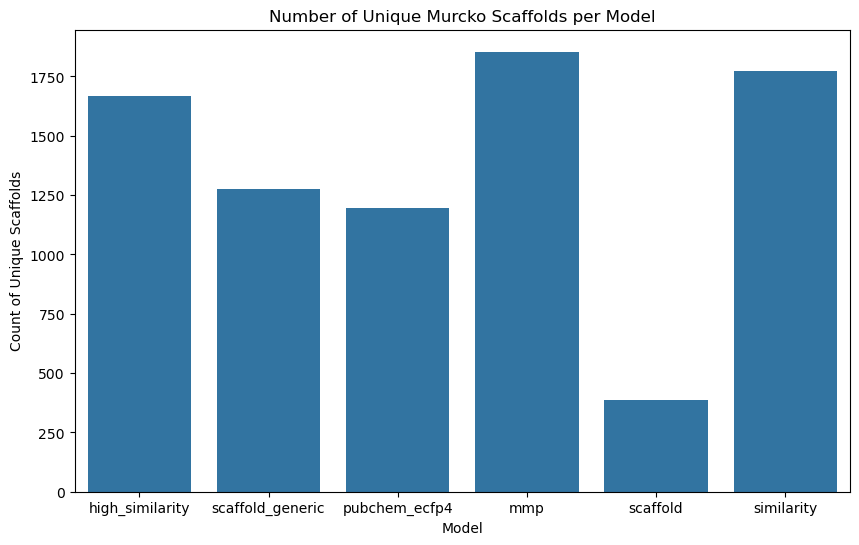

Number of Murcko Scaffolds common to ALL models: 24
Example common scaffolds (first 3):


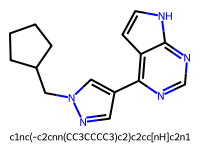

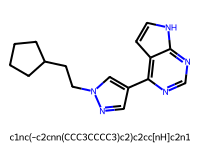

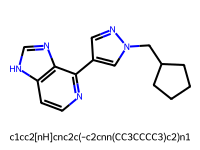


--- Analyzing Side Chain Overlap ---
Model high_similarity: 892 unique side chains
Model scaffold_generic: 1225 unique side chains
Model pubchem_ecfp4: 1001 unique side chains
Model mmp: 2105 unique side chains
Model scaffold: 1550 unique side chains
Model similarity: 1019 unique side chains

Venn diagrams are supported for 2 or 3 models only. Using bar chart for all models.


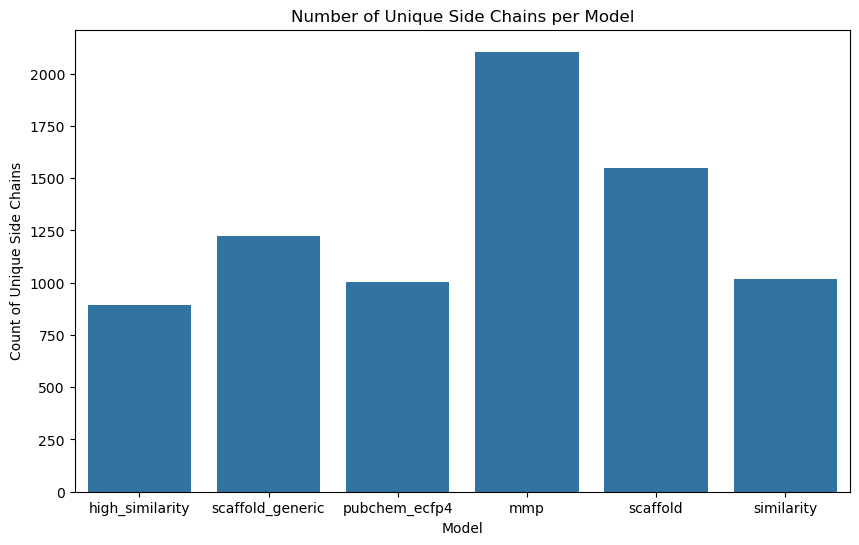

Number of Side Chains common to ALL models: 117
Example common side chains (first 3):


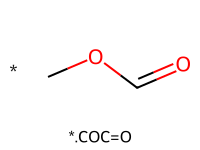

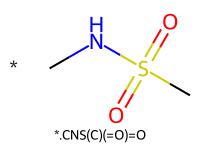

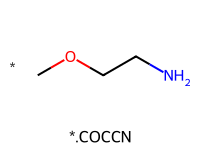


--- Overlap Analysis Complete ---
These visualizations help understand the diversity and commonality of generated structures across different models.


In [11]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3 # Venn図の描画ライブラリ (必要に応じてインストール: pip install matplotlib-venn)
import warnings

warnings.filterwarnings('ignore') # プロット時の警告を非表示にすることがあります

print("--- Step 6: Visualizing Overlap of Scaffolds and Side Chains Across Models ---")

# モデル情報の取得
if 'model' not in df.columns:
    print("Error: 'model' column not found in df. Cannot perform model-wise analysis.")
else:
    unique_models = df['model'].unique()
    print(f"Found {len(unique_models)} unique models: {unique_models}")

    if len(unique_models) < 2:
        print("Not enough unique models to compare overlaps. At least 2 models are required.")
    else:
        # モデルごとのMurcko ScaffoldとSide Chainのセットを作成
        model_scaffolds = {model: set() for model in unique_models}
        model_side_chains = {model: set() for model in unique_models}

        # df と scaffold_side_chain_df をマージして、各SMILESに対応するモデル情報を取得
        # df と scaffold_side_chain_df は Original_SMILES で結合可能
        df_with_scaffold_side_chain = pd.merge(
            df[['SMILES', 'model']], # 元のdfからSMILESとmodelだけを使う
            scaffold_side_chain_df,
            left_on='SMILES',
            right_on='Original_SMILES',
            how='inner' # 共通する分子のみを対象
        ).drop_duplicates(subset=['SMILES', 'model', 'Murcko_SMILES', 'Side_Chain_SMILES'])


        print("\n--- Analyzing Murcko Scaffold Overlap ---")
        for model in unique_models:
            scaffolds_in_model = df_with_scaffold_side_chain[
                df_with_scaffold_side_chain['model'] == model
            ]['Murcko_SMILES'].unique()
            model_scaffolds[model].update(scaffolds_in_model)
            print(f"Model {model}: {len(scaffolds_in_model)} unique scaffolds")

        # Murcko Scaffoldのオーバーラップ可視化
        if len(unique_models) == 2:
            model1, model2 = list(unique_models)[:2]
            plt.figure(figsize=(8, 8))
            venn2([model_scaffolds[model1], model_scaffolds[model2]], set_labels=(f'Scaffolds in {model1}', f'Scaffolds in {model2}'))
            plt.title('Overlap of Murcko Scaffolds between Two Models')
            plt.show()
        elif len(unique_models) == 3:
            model1, model2, model3 = list(unique_models)[:3]
            plt.figure(figsize=(10, 10))
            venn3([model_scaffolds[model1], model_scaffolds[model2], model_scaffolds[model3]], set_labels=(f'{model1}', f'{model2}', f'{model3}'))
            plt.title('Overlap of Murcko Scaffolds between Three Models')
            plt.show()
        else:
            print("\nVenn diagrams are supported for 2 or 3 models only. Using bar chart for all models.")
            # 各モデルが生成したユニークなMurcko Scaffoldの数を棒グラフで表示
            scaffold_counts_per_model = {model: len(s) for model, s in model_scaffolds.items()}
            plt.figure(figsize=(10, 6))
            sns.barplot(x=list(scaffold_counts_per_model.keys()), y=list(scaffold_counts_per_model.values()))
            plt.title('Number of Unique Murcko Scaffolds per Model')
            plt.xlabel('Model')
            plt.ylabel('Count of Unique Scaffolds')
            plt.show()

            # 全モデルで共通するMurcko Scaffoldの数を計算 (共通集合)
            if model_scaffolds:
                common_scaffolds = set.intersection(*model_scaffolds.values())
                print(f"Number of Murcko Scaffolds common to ALL models: {len(common_scaffolds)}")
                if common_scaffolds:
                    print("Example common scaffolds (first 3):")
                    for i, smi in enumerate(list(common_scaffolds)[:3]):
                        mol = Chem.MolFromSmiles(smi)
                        if mol:
                            display(Draw.MolToImage(mol, size=(200, 150), legend=smi))


        print("\n--- Analyzing Side Chain Overlap ---")
        for model in unique_models:
            side_chains_in_model = df_with_scaffold_side_chain[
                df_with_scaffold_side_chain['model'] == model
            ]['Side_Chain_SMILES'].unique()
            model_side_chains[model].update(side_chains_in_model)
            print(f"Model {model}: {len(side_chains_in_model)} unique side chains")

        # Side Chainのオーバーラップ可視化 (Murcko Scaffoldと同様のロジック)
        if len(unique_models) == 2:
            model1, model2 = list(unique_models)[:2]
            plt.figure(figsize=(8, 8))
            venn2([model_side_chains[model1], model_side_chains[model2]], set_labels=(f'Side Chains in {model1}', f'Side Chains in {model2}'))
            plt.title('Overlap of Side Chains between Two Models')
            plt.show()
        elif len(unique_models) == 3:
            model1, model2, model3 = list(unique_models)[:3]
            plt.figure(figsize=(10, 10))
            venn3([model_side_chains[model1], model_side_chains[model2], model_side_chains[model3]], set_labels=(f'{model1}', f'{model2}', f'{model3}'))
            plt.title('Overlap of Side Chains between Three Models')
            plt.show()
        else:
            print("\nVenn diagrams are supported for 2 or 3 models only. Using bar chart for all models.")
            # 各モデルが生成したユニークなSide Chainの数を棒グラフで表示
            side_chain_counts_per_model = {model: len(s) for model, s in model_side_chains.items()}
            plt.figure(figsize=(10, 6))
            sns.barplot(x=list(side_chain_counts_per_model.keys()), y=list(side_chain_counts_per_model.values()))
            plt.title('Number of Unique Side Chains per Model')
            plt.xlabel('Model')
            plt.ylabel('Count of Unique Side Chains')
            plt.show()

            # 全モデルで共通するSide Chainの数を計算 (共通集合)
            if model_side_chains:
                common_side_chains = set.intersection(*model_side_chains.values())
                print(f"Number of Side Chains common to ALL models: {len(common_side_chains)}")
                if common_side_chains:
                    print("Example common side chains (first 3):")
                    for i, smi in enumerate(list(common_side_chains)[:3]):
                        mol = Chem.MolFromSmiles(smi)
                        if mol:
                            display(Draw.MolToImage(mol, size=(200, 150), legend=smi))

print("\n--- Overlap Analysis Complete ---")
print("These visualizations help understand the diversity and commonality of generated structures across different models.")

Flow of Scaffolds and Side Chains from Models 

--- Step 7: Generating Sankey Diagram for Model-Scaffold-Side Chain Flow (最終調整版 + Scaffold ID化) ---
Filtered 779 rows. Remaining 49031 rows for Sankey.



--- Visualizing Top Scaffolds used in Sankey Diagram ---


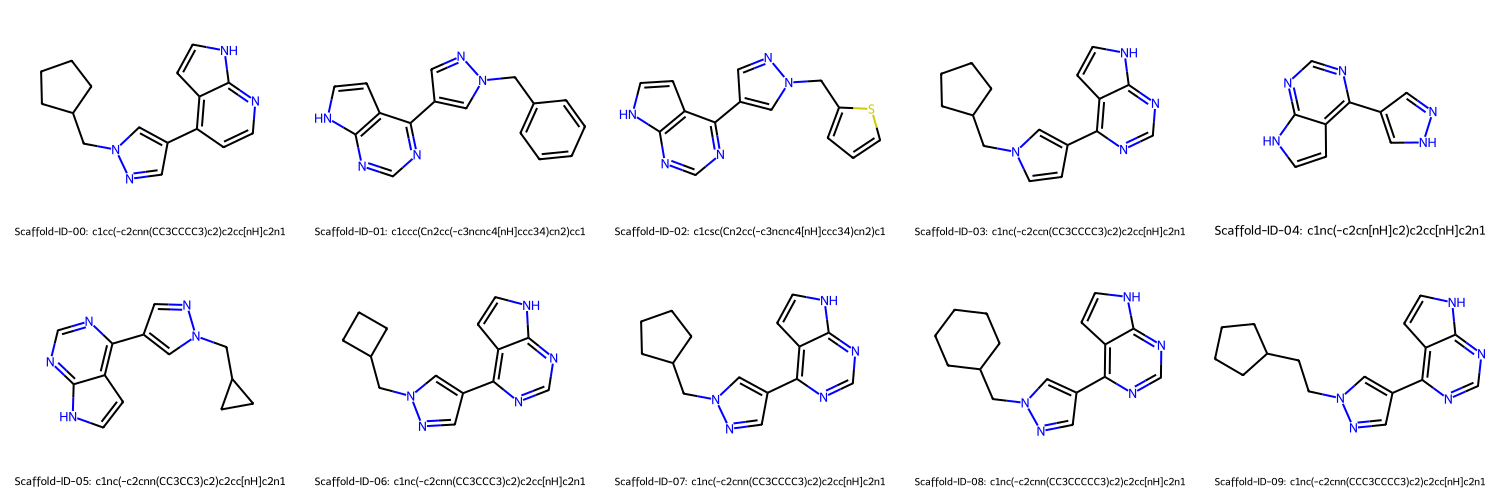


--- Visualizing Top Side Chains used in Sankey Diagram ---


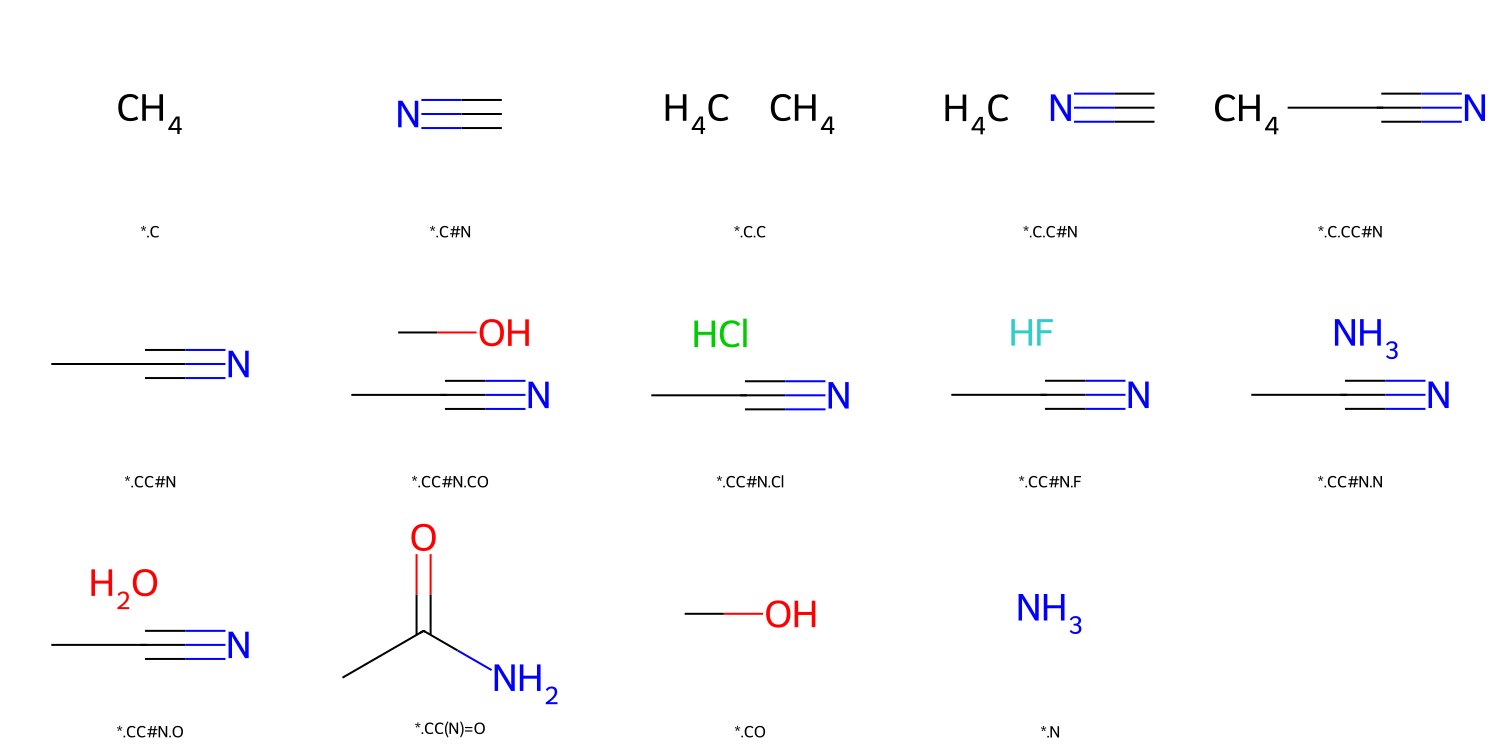


--- Sankey Diagram and Structure Visualization Complete ---


In [12]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, Image
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

# df_with_scaffold_side_chain が既に作成されていることを前提とします。

print("--- Step 7: Generating Sankey Diagram for Model-Scaffold-Side Chain Flow (最終調整版 + Scaffold ID化) ---")

if 'model' not in df_with_scaffold_side_chain.columns:
    print("Error: 'model' column not found in the merged DataFrame. Please ensure df_with_scaffold_side_chain is correctly prepared.")
else:
    # --- 設定 ---
    MODELS_TO_INCLUDE = df_with_scaffold_side_chain['model'].unique().tolist()
    TOP_N_SCAFFOLDS_SANKEY = 10
    TOP_N_SIDE_CHAINS_SANKEY = 15 
    SANKEY_PLOT_HEIGHT = 800
    
    SMARTS_TO_COMPLETELY_EXCLUDE_FROM_SANKEY = {
        'C1CCCC1',  # シクロペンタン環
        'C1CCCCC1', # シクロヘキサン環
        'C1CCC1',   # シクロブタン環
        'C1CC1',    # シクロプロパン環
        'c1ccccc1', # ベンゼン環 (もしこれらを分析の「主要な骨格」から除外したい場合)
    }
    # -----------------

    initial_rows = len(df_with_scaffold_side_chain)
    
    df_filtered_for_sankey = df_with_scaffold_side_chain[
        (~df_with_scaffold_side_chain['Murcko_SMILES'].isin(SMARTS_TO_COMPLETELY_EXCLUDE_FROM_SANKEY)) &
        (~df_with_scaffold_side_chain['Side_Chain_SMILES'].isin(SMARTS_TO_COMPLETELY_EXCLUDE_FROM_SANKEY))
    ].copy()
    
    print(f"Filtered {initial_rows - len(df_filtered_for_sankey)} rows. Remaining {len(df_filtered_for_sankey)} rows for Sankey.")
    
    label_list = []
    source_indices = []
    target_indices = []
    value_list = []

    node_map = {}
    current_node_idx = 0

    # **追加:** Scaffold SMILES とそのIDをマッピングするための辞書
    scaffold_smi_to_id_map = {} 
    next_scaffold_id = 0

    def get_node_idx(label):
        global current_node_idx
        if label not in node_map:
            node_map[label] = current_node_idx
            label_list.append(label)
            current_node_idx += 1
        return node_map[label]

    # **変更:** ScaffoldのSMILESにIDを割り当ててからノードを作成
    model_node_idxs = {model: get_node_idx(f"Model: {model}") for model in MODELS_TO_INCLUDE}

    model_scaffold_counts = df_filtered_for_sankey.groupby(['model', 'Murcko_SMILES']).size().reset_index(name='count')
    overall_scaffold_counts = df_filtered_for_sankey['Murcko_SMILES'].value_counts()
    top_scaffolds_to_include_smi = overall_scaffold_counts.head(TOP_N_SCAFFOLDS_SANKEY).index.tolist() # 元のSMILESを保持

    scaffold_node_idxs = {}
    
    for _, row in model_scaffold_counts.iterrows():
        model = row['model']
        scaffold_smi = row['Murcko_SMILES']
        count = row['count']

        if model in MODELS_TO_INCLUDE and scaffold_smi in top_scaffolds_to_include_smi:
            # SMILESにIDを割り当てる
            if scaffold_smi not in scaffold_smi_to_id_map:
                scaffold_smi_to_id_map[scaffold_smi] = f"Scaffold-ID-{next_scaffold_id:02d}"
                next_scaffold_id += 1
            
            scaffold_id_label = scaffold_smi_to_id_map[scaffold_smi] # IDラベルを取得
            scaffold_label_for_sankey = f"Scaffold: {scaffold_id_label}" # Sankey表示用ラベル
            
            scaffold_idx = get_node_idx(scaffold_label_for_sankey)
            scaffold_node_idxs[scaffold_smi] = scaffold_idx # SMILESをキーとしてインデックスを保持

            source_indices.append(model_node_idxs[model])
            target_indices.append(scaffold_idx)
            value_list.append(count)

    overall_side_chain_counts = df_filtered_for_sankey['Side_Chain_SMILES'].value_counts()
    top_side_chains_to_include = overall_side_chain_counts.head(TOP_N_SIDE_CHAINS_SANKEY).index.tolist()

    def remove_dummy_atoms(smi):
        if '*' not in smi:
            return smi
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            return None
        rwmol = Chem.RWMol(mol)
        dummy_atoms = [atom for atom in rwmol.GetAtoms() if atom.GetAtomicNum() == 0]
        for atom in dummy_atoms:
            rwmol.RemoveAtom(atom.GetIdx())
        # ダミーアトム削除後に有効なSMILESが残るかチェック
        try:
            return Chem.MolToSmiles(rwmol)
        except:
            return None # 失敗した場合はNoneを返す


    scaffold_side_chain_counts = df_filtered_for_sankey.groupby(['Murcko_SMILES', 'Side_Chain_SMILES']).size().reset_index(name='count')

    for _, row in scaffold_side_chain_counts.iterrows():
        scaffold_smi = row['Murcko_SMILES']
        side_chain_smi = row['Side_Chain_SMILES']
        count = row['count']

        if (scaffold_smi in top_scaffolds_to_include_smi and # SMILESリストと比較
            side_chain_smi in top_side_chains_to_include):
            if scaffold_smi in scaffold_node_idxs: # ここはSMILESでキーを探す
                side_chain_label = f"Side Chain: {side_chain_smi}"
                side_chain_idx = get_node_idx(side_chain_label)

                source_indices.append(scaffold_node_idxs[scaffold_smi])
                target_indices.append(side_chain_idx)
                value_list.append(count)

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=label_list,
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=value_list,
        ))])

    fig.update_layout(
        title_text=f"Flow of Scaffolds and Side Chains from Models (Top {TOP_N_SCAFFOLDS_SANKEY} Scaffolds, Top {TOP_N_SIDE_CHAINS_SANKEY} Side Chains)",
        font_size=10,
        height=SANKEY_PLOT_HEIGHT
    )
    fig.show()

    # --- 構造描画コード (変更あり) ---
    print("\n--- Visualizing Top Scaffolds used in Sankey Diagram ---")
    sankey_scaffold_mols_to_draw = []
    sankey_scaffold_legends = []

    # **変更:** scaffold_smi_to_id_map を使ってIDとSMILESのペアを処理
    # ID順にソートして描画すると分かりやすい
    sorted_scaffold_items = sorted(scaffold_smi_to_id_map.items(), key=lambda item: item[1]) # IDでソート

    for smi, scaffold_id in sorted_scaffold_items:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            sankey_scaffold_mols_to_draw.append(mol)
            sankey_scaffold_legends.append(f"{scaffold_id}: {smi}") # IDとSMILESを両方表示

    if sankey_scaffold_mols_to_draw:
        scaffold_img = Draw.MolsToGridImage(
            sankey_scaffold_mols_to_draw,
            molsPerRow=min(len(sankey_scaffold_mols_to_draw), 5), 
            legends=sankey_scaffold_legends,
            subImgSize=(300, 250)
        )
        display(scaffold_img)
    else:
        print("No valid top scaffolds to display for Sankey Diagram.")

    print("\n--- Visualizing Top Side Chains used in Sankey Diagram ---")
    sankey_side_chain_mols_to_draw = []
    sankey_side_chain_legends = []

    processed_side_chains_dict = {} # 処理済みSMILESとその元のSMILESを保持
    for smi in top_side_chains_to_include:
        processed_smi = remove_dummy_atoms(smi)
        if processed_smi is not None:
            # 処理済みSMILESが同じでも元のSMILESは異なる場合があるので、元のSMILESも保持
            processed_side_chains_dict[smi] = processed_smi 

    # 実際に描画するSMILESのセット (重複排除のため)
    unique_processed_side_chains = set(processed_side_chains_dict.values())


    for original_smi in top_side_chains_to_include:
        processed_smi = processed_side_chains_dict.get(original_smi) # 処理済みSMILESを取得
        if processed_smi and processed_smi in unique_processed_side_chains: # 有効かつ未描画であれば
            mol = Chem.MolFromSmiles(processed_smi)
            if mol:
                sankey_side_chain_mols_to_draw.append(mol)
                # ここでは元のSMILESをキャプションにする
                sankey_side_chain_legends.append(original_smi) 
                unique_processed_side_chains.remove(processed_smi) # 描画済みとしてマーク

    # SMILESでソートして表示すると、並びが安定しやすい
    # sankey_side_chain_mols_to_draw と sankey_side_chain_legends は、リストのペアになっているはずなので、
    # SMILESに基づいてソートする
    combined = sorted(zip(sankey_side_chain_legends, sankey_side_chain_mols_to_draw))
    sankey_side_chain_legends_sorted = [item[0] for item in combined]
    sankey_side_chain_mols_to_draw_sorted = [item[1] for item in combined]


    if sankey_side_chain_mols_to_draw_sorted:
        side_chain_img = Draw.MolsToGridImage(
            sankey_side_chain_mols_to_draw_sorted,
            molsPerRow=min(len(sankey_side_chain_mols_to_draw_sorted), 5), 
            legends=sankey_side_chain_legends_sorted,
            subImgSize=(300, 250)
        )
        display(side_chain_img)
    else:
        print("No valid top side chains to display for Sankey Diagram.")

print("\n--- Sankey Diagram and Structure Visualization Complete ---")

特定のモデルについてのMMPリレーション

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, Image
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

# df_with_scaffold_side_chain が既に作成されていることを前提とします。

print("--- Step 7: Generating Sankey Diagram for Model-Scaffold-Side Chain Flow (特定のモデルに限定) ---")

# --- ▼▼▼ ここを編集して表示させたいモデルを指定 ▼▼▼ ---
TARGET_MODELS_FOR_SANKEY = ['Model A'] # 例: 'Model A' と 'Model B' のみを表示
# TARGET_MODELS_FOR_SANKEY = ['Model A'] # 例: 'Model A' のみを表示
# TARGET_MODELS_FOR_SANKEY = ['Model C', 'Model D', 'Model E'] # 複数のモデルを指定可能
# ▲▲▲ ここを編集 ▲▲▲ ---

if 'model' not in df_with_scaffold_side_chain.columns:
    print("Error: 'model' column not found in the merged DataFrame. Please ensure df_with_scaffold_side_chain is correctly prepared.")
else:
    # --- 設定 ---
    # MODELS_TO_INCLUDE は TARGET_MODELS_FOR_SANKEY に置き換えられます
    TOP_N_SCAFFOLDS_SANKEY = 10
    TOP_N_SIDE_CHAINS_SANKEY = 15 
    SANKEY_PLOT_HEIGHT = 800
    
    SMARTS_TO_COMPLETELY_EXCLUDE_FROM_SANKEY = {
        'C1CCCC1',  # シクロペンタン環
        'C1CCCCC1', # シクロヘキサン環
        'C1CCC1',   # シクロブタン環
        'C1CC1',    # シクロプロパン環
        'c1ccccc1', # ベンゼン環 (もしこれらを分析の「主要な骨格」から除外したい場合)
    }
    # -----------------

    initial_rows = len(df_with_scaffold_side_chain)
    
    # フィルタリングされたデータフレームを、指定されたモデルとSMILES除外条件に基づいて作成
    df_filtered_for_sankey = df_with_scaffold_side_chain[
        df_with_scaffold_side_chain['model'].isin(TARGET_MODELS_FOR_SANKEY) & # 指定モデルでフィルタリング
        (~df_with_scaffold_side_chain['Murcko_SMILES'].isin(SMARTS_TO_COMPLETELY_EXCLUDE_FROM_SANKEY)) &
        (~df_with_scaffold_side_chain['Side_Chain_SMILES'].isin(SMARTS_TO_COMPLETELY_EXCLUDE_FROM_SANKEY))
    ].copy()
    
    print(f"Filtered {initial_rows - len(df_filtered_for_sankey)} rows. Remaining {len(df_filtered_for_sankey)} rows for Sankey.")

    if df_filtered_for_sankey.empty:
        print("No data available for the specified models after filtering. Please check your model names or data.")
        # ここで処理を終了
        exit() # あるいは return

    label_list = []
    source_indices = []
    target_indices = []
    value_list = []

    node_map = {}
    current_node_idx = 0

    scaffold_smi_to_id_map = {} 
    next_scaffold_id = 0

    def get_node_idx(label):
        global current_node_idx
        if label not in node_map:
            node_map[label] = current_node_idx
            label_list.append(label)
            current_node_idx += 1
        return node_map[label]

    # モデルノードのインデックスを生成（指定されたモデルのみ）
    model_node_idxs = {model: get_node_idx(f"Model: {model}") for model in TARGET_MODELS_FOR_SANKEY}

    # df_filtered_for_sankey を使用
    model_scaffold_counts = df_filtered_for_sankey.groupby(['model', 'Murcko_SMILES']).size().reset_index(name='count')
    overall_scaffold_counts = df_filtered_for_sankey['Murcko_SMILES'].value_counts()
    top_scaffolds_to_include_smi = overall_scaffold_counts.head(TOP_N_SCAFFOLDS_SANKEY).index.tolist() 

    scaffold_node_idxs = {}
    
    for _, row in model_scaffold_counts.iterrows():
        model = row['model']
        scaffold_smi = row['Murcko_SMILES']
        count = row['count']

        # 指定モデルかつ上位の足場SMILESである場合のみ処理
        if model in TARGET_MODELS_FOR_SANKEY and scaffold_smi in top_scaffolds_to_include_smi:
            if scaffold_smi not in scaffold_smi_to_id_map:
                scaffold_smi_to_id_map[scaffold_smi] = f"Scaffold-ID-{next_scaffold_id:02d}"
                next_scaffold_id += 1
            
            scaffold_id_label = scaffold_smi_to_id_map[scaffold_smi] 
            scaffold_label_for_sankey = f"Scaffold: {scaffold_id_label}" 
            
            scaffold_idx = get_node_idx(scaffold_label_for_sankey)
            scaffold_node_idxs[scaffold_smi] = scaffold_idx 

            source_indices.append(model_node_idxs[model])
            target_indices.append(scaffold_idx)
            value_list.append(count)

    # df_filtered_for_sankey を使用
    overall_side_chain_counts = df_filtered_for_sankey['Side_Chain_SMILES'].value_counts()
    top_side_chains_to_include = overall_side_chain_counts.head(TOP_N_SIDE_CHAINS_SANKEY).index.tolist()

    def remove_dummy_atoms(smi):
        if '*' not in smi:
            return smi
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            return None
        rwmol = Chem.RWMol(mol)
        dummy_atoms = [atom for atom in rwmol.GetAtoms() if atom.GetAtomicNum() == 0]
        for atom in dummy_atoms:
            rwmol.RemoveAtom(atom.GetIdx())
        try:
            return Chem.MolToSmiles(rwmol)
        except:
            return None 


    scaffold_side_chain_counts = df_filtered_for_sankey.groupby(['Murcko_SMILES', 'Side_Chain_SMILES']).size().reset_index(name='count')

    for _, row in scaffold_side_chain_counts.iterrows():
        scaffold_smi = row['Murcko_SMILES']
        side_chain_smi = row['Side_Chain_SMILES']
        count = row['count']

        if (scaffold_smi in top_scaffolds_to_include_smi and 
            side_chain_smi in top_side_chains_to_include):
            if scaffold_smi in scaffold_node_idxs: 
                side_chain_label = f"Side Chain: {side_chain_smi}"
                side_chain_idx = get_node_idx(side_chain_label)

                source_indices.append(scaffold_node_idxs[scaffold_smi])
                target_indices.append(side_chain_idx)
                value_list.append(count)

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=label_list,
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=value_list,
        ))])

    # タイトルに選択されたモデル名を追加
    selected_models_str = ", ".join(TARGET_MODELS_FOR_SANKEY)
    fig.update_layout(
        title_text=f"Flow of Scaffolds and Side Chains for Models: {selected_models_str} (Top {TOP_N_SCAFFOLDS_SANKEY} Scaffolds, Top {TOP_N_SIDE_CHAINS_SANKEY} Side Chains)",
        font_size=10,
        height=SANKEY_PLOT_HEIGHT
    )
    fig.show()

    # --- 構造描画コード ---
    print("\n--- Visualizing Top Scaffolds used in Sankey Diagram ---")
    sankey_scaffold_mols_to_draw = []
    sankey_scaffold_legends = []

    sorted_scaffold_items = sorted(scaffold_smi_to_id_map.items(), key=lambda item: item[1])

    for smi, scaffold_id in sorted_scaffold_items:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            sankey_scaffold_mols_to_draw.append(mol)
            sankey_scaffold_legends.append(f"{scaffold_id}: {smi}")

    if sankey_scaffold_mols_to_draw:
        scaffold_img = Draw.MolsToGridImage(
            sankey_scaffold_mols_to_draw,
            molsPerRow=min(len(sankey_scaffold_mols_to_draw), 5), 
            legends=sankey_scaffold_legends,
            subImgSize=(300, 250)
        )
        display(scaffold_img)
    else:
        print("No valid top scaffolds to display for Sankey Diagram.")

    print("\n--- Visualizing Top Side Chains used in Sankey Diagram ---")
    sankey_side_chain_mols_to_draw = []
    sankey_side_chain_legends = []

    processed_side_chains_dict = {} 
    for smi in top_side_chains_to_include:
        processed_smi = remove_dummy_atoms(smi)
        if processed_smi is not None:
            processed_side_chains_dict[smi] = processed_smi 

    unique_processed_side_chains_set = set(processed_side_chains_dict.values()) # ユニークな処理済みSMILESを管理

    # 描画対象となる Side Chain の元のSMILESを収集し、ソート
    side_chain_smi_to_draw = []
    for original_smi in top_side_chains_to_include:
        processed_smi = processed_side_chains_dict.get(original_smi)
        if processed_smi and processed_smi in unique_processed_side_chains_set:
            side_chain_smi_to_draw.append(original_smi)
            unique_processed_side_chains_set.remove(processed_smi) # 描画済みとしてマーク

    # SMILESでソートして表示
    side_chain_smi_to_draw.sort() 

    for original_smi in side_chain_smi_to_draw:
        processed_smi = processed_side_chains_dict[original_smi] # 処理済みSMILESを取得
        mol = Chem.MolFromSmiles(processed_smi)
        if mol:
            sankey_side_chain_mols_to_draw.append(mol)
            sankey_side_chain_legends.append(original_smi) 
    

    if sankey_side_chain_mols_to_draw:
        side_chain_img = Draw.MolsToGridImage(
            sankey_side_chain_mols_to_draw,
            molsPerRow=min(len(sankey_side_chain_mols_to_draw), 5), 
            legends=sankey_side_chain_legends,
            subImgSize=(300, 250)
        )
        display(side_chain_img)
    else:
        print("No valid top side chains to display for Sankey Diagram.")

print("\n--- Sankey Diagram and Structure Visualization Complete ---")

--- Step 7: Generating Sankey Diagram for Model-Scaffold-Side Chain Flow (特定のモデルに限定) ---
Filtered 49810 rows. Remaining 0 rows for Sankey.
No data available for the specified models after filtering. Please check your model names or data.



--- Visualizing Top Scaffolds used in Sankey Diagram ---
No valid top scaffolds to display for Sankey Diagram.

--- Visualizing Top Side Chains used in Sankey Diagram ---
No valid top side chains to display for Sankey Diagram.

--- Sankey Diagram and Structure Visualization Complete ---


: 